# Exploratory Data Analysis of Teams dataset

In [388]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

teams = pd.read_csv('basketballPlayoffs/teams.csv', delimiter=",")

teams.head()

,year,lgID,tmID,franchID,confID,divID,rank,playoff,seeded,firstRound,...,GP,homeW,homeL,awayW,awayL,confW,confL,min,attend,arena
0,9,WNBA,ATL,ATL,EA,NaN,7,N,0,NaN,...,34,1,16,3,14,2,18,6825,141379,Philips Arena
1,10,WNBA,ATL,ATL,EA,NaN,2,Y,0,L,...,34,12,5,6,11,10,12,6950,120737,Philips Arena
2,1,WNBA,CHA,CHA,EA,NaN,8,N,0,NaN,...,32,5,11,3,13,5,16,6475,90963,Charlotte Coliseum
3,2,WNBA,CHA,CHA,EA,NaN,4,Y,0,W,...,32,11,5,7,9,15,6,6500,105525,Charlotte Coliseum
4,3,WNBA,CHA,CHA,EA,NaN,2,Y,0,L,...,32,11,5,7,9,12,9,6450,106670,Charlotte Coliseum


In [389]:
def shift_target_variable(dataset):
    dataset.sort_values(by=['tmID', 'year'], inplace=True)

    dataset['playoffs'] = dataset.groupby('tmID')['playoff'].shift(-1)

    dataset.drop(columns=['playoff'], inplace=True)

    dataset.dropna(subset=['playoffs'], inplace=True)

    dataset.rename(columns={'playoffs': 'playoff'}, inplace=True)

    dataset.reset_index(drop=True, inplace=True)

    return dataset

In [390]:
teams = shift_target_variable(teams)

In [391]:
for column in teams.columns:
    unique_values = teams[column].unique()
    print(f"Number of different values in the {column} column are:", len(unique_values))
    print("------------")

Number of different values in the year column are: 9
------------
Number of different values in the lgID column are: 1
------------
Number of different values in the tmID column are: 20
------------
Number of different values in the franchID column are: 18
------------
Number of different values in the confID column are: 2
------------
Number of different values in the divID column are: 1
------------
Number of different values in the rank column are: 8
------------
Number of different values in the seeded column are: 1
------------
Number of different values in the firstRound column are: 3
------------
Number of different values in the semis column are: 3
------------
Number of different values in the finals column are: 3
------------
Number of different values in the name column are: 20
------------
Number of different values in the o_fgm column are: 100
------------
Number of different values in the o_fga column are: 114
------------
Number of different values in the o_ftm column ar

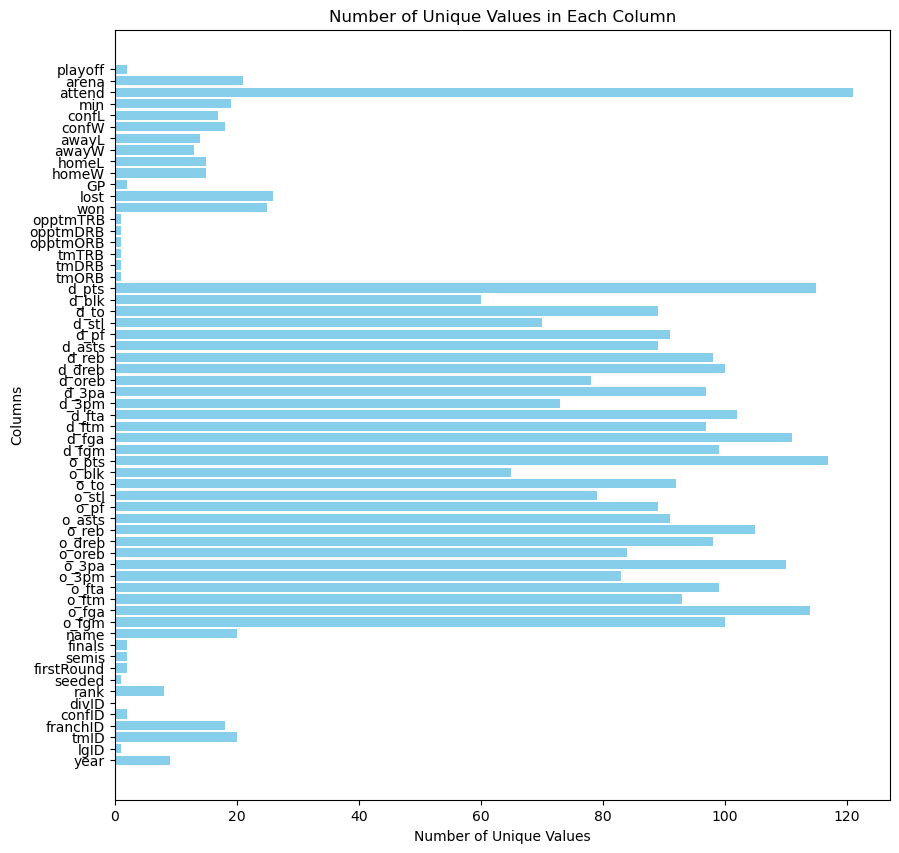

In [392]:
columns = []
value_counts = []

for column in teams.columns:
    unique_values = teams[column].nunique()
    columns.append(column)
    value_counts.append(unique_values)

plt.figure(figsize=(10, 10))
plt.barh(columns, value_counts, color='skyblue')
plt.xlabel('Number of Unique Values')
plt.ylabel('Columns')
plt.title('Number of Unique Values in Each Column')
plt.show()

In [393]:
teams.isnull().sum()

year        0
lgID        0
tmID        0
franchID    0
confID      0
           ..
confL       0
min         0
attend      0
arena       0
playoff     0
Length: 61, dtype: int64

In [394]:
print(teams.dtypes)

year         int64
lgID        object
tmID        object
franchID    object
confID      object
             ...  
confL        int64
min          int64
attend       int64
arena       object
playoff     object
Length: 61, dtype: object


In [395]:
teams_original = teams.copy()

for column in teams.columns:
    if teams[column].dtype == 'object':
        teams[column] = teams[column].astype('category').cat.codes

teams.describe()

,year,lgID,tmID,franchID,confID,divID,rank,seeded,firstRound,semis,...,homeW,homeL,awayW,awayL,confW,confL,min,attend,arena,playoff
count,122.000000,122.0,122.000000,122.000000,122.000000,0.0,122.000000,122.0,122.000000,122.000000,...,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000
mean,4.844262,0.0,10.163934,9.549180,0.516393,NaN,4.073770,0.0,-0.139344,-0.573770,...,10.090164,6.549180,6.573770,10.065574,10.573770,10.557377,6721.450820,142667.614754,10.590164,0.581967
std,2.647377,0.0,5.361881,4.838042,0.501792,NaN,2.151947,0.0,0.836320,0.737631,...,3.128129,3.104522,2.825264,2.839327,3.613377,3.629651,197.198817,35704.000482,6.320312,0.495270
min,1.000000,0.0,0.000000,0.000000,0.000000,NaN,1.000000,0.0,-1.000000,-1.000000,...,1.000000,0.000000,1.000000,3.000000,2.000000,2.000000,6400.000000,57635.000000,0.000000,0.000000
25%,2.000000,0.0,6.000000,6.000000,0.000000,NaN,2.000000,0.0,-1.000000,-1.000000,...,8.000000,4.000000,5.000000,8.000000,8.000000,8.000000,6475.000000,122150.000000,6.000000,0.000000
50%,5.000000,0.0,10.000000,10.000000,1.000000,NaN,4.000000,0.0,0.000000,-1.000000,...,10.000000,6.000000,6.500000,10.000000,11.000000,10.000000,6825.000000,137594.000000,10.000000,1.000000
75%,7.000000,0.0,15.000000,14.000000,1.000000,NaN,6.000000,0.0,1.000000,0.000000,...,12.000000,9.000000,8.000000,12.000000,13.000000,13.000000,6875.000000,153116.500000,16.000000,1.000000
max,9.000000,0.0,19.000000,17.000000,1.000000,NaN,8.000000,0.0,1.000000,1.000000,...,16.000000,16.000000,13.000000,16.000000,19.000000,19.000000,7000.000000,259237.000000,20.000000,1.000000


In [396]:
def correlation_matrix(dataframe):
    corr_matrix = dataframe.corr()

    target_correlation = corr_matrix['playoff']

    plt.figure(figsize=(30, 20))

    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    sns.heatmap(corr_matrix, mask=mask, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidths=0.5, fmt=".2f")

    plt.title('Correlation Matrix', fontsize=16)
    plt.show()

    dict = {}

    for feature, correlation in target_correlation.items():
        print(f"Correlation between target and {feature}: {correlation}")
        dict[feature] = correlation

    return dict

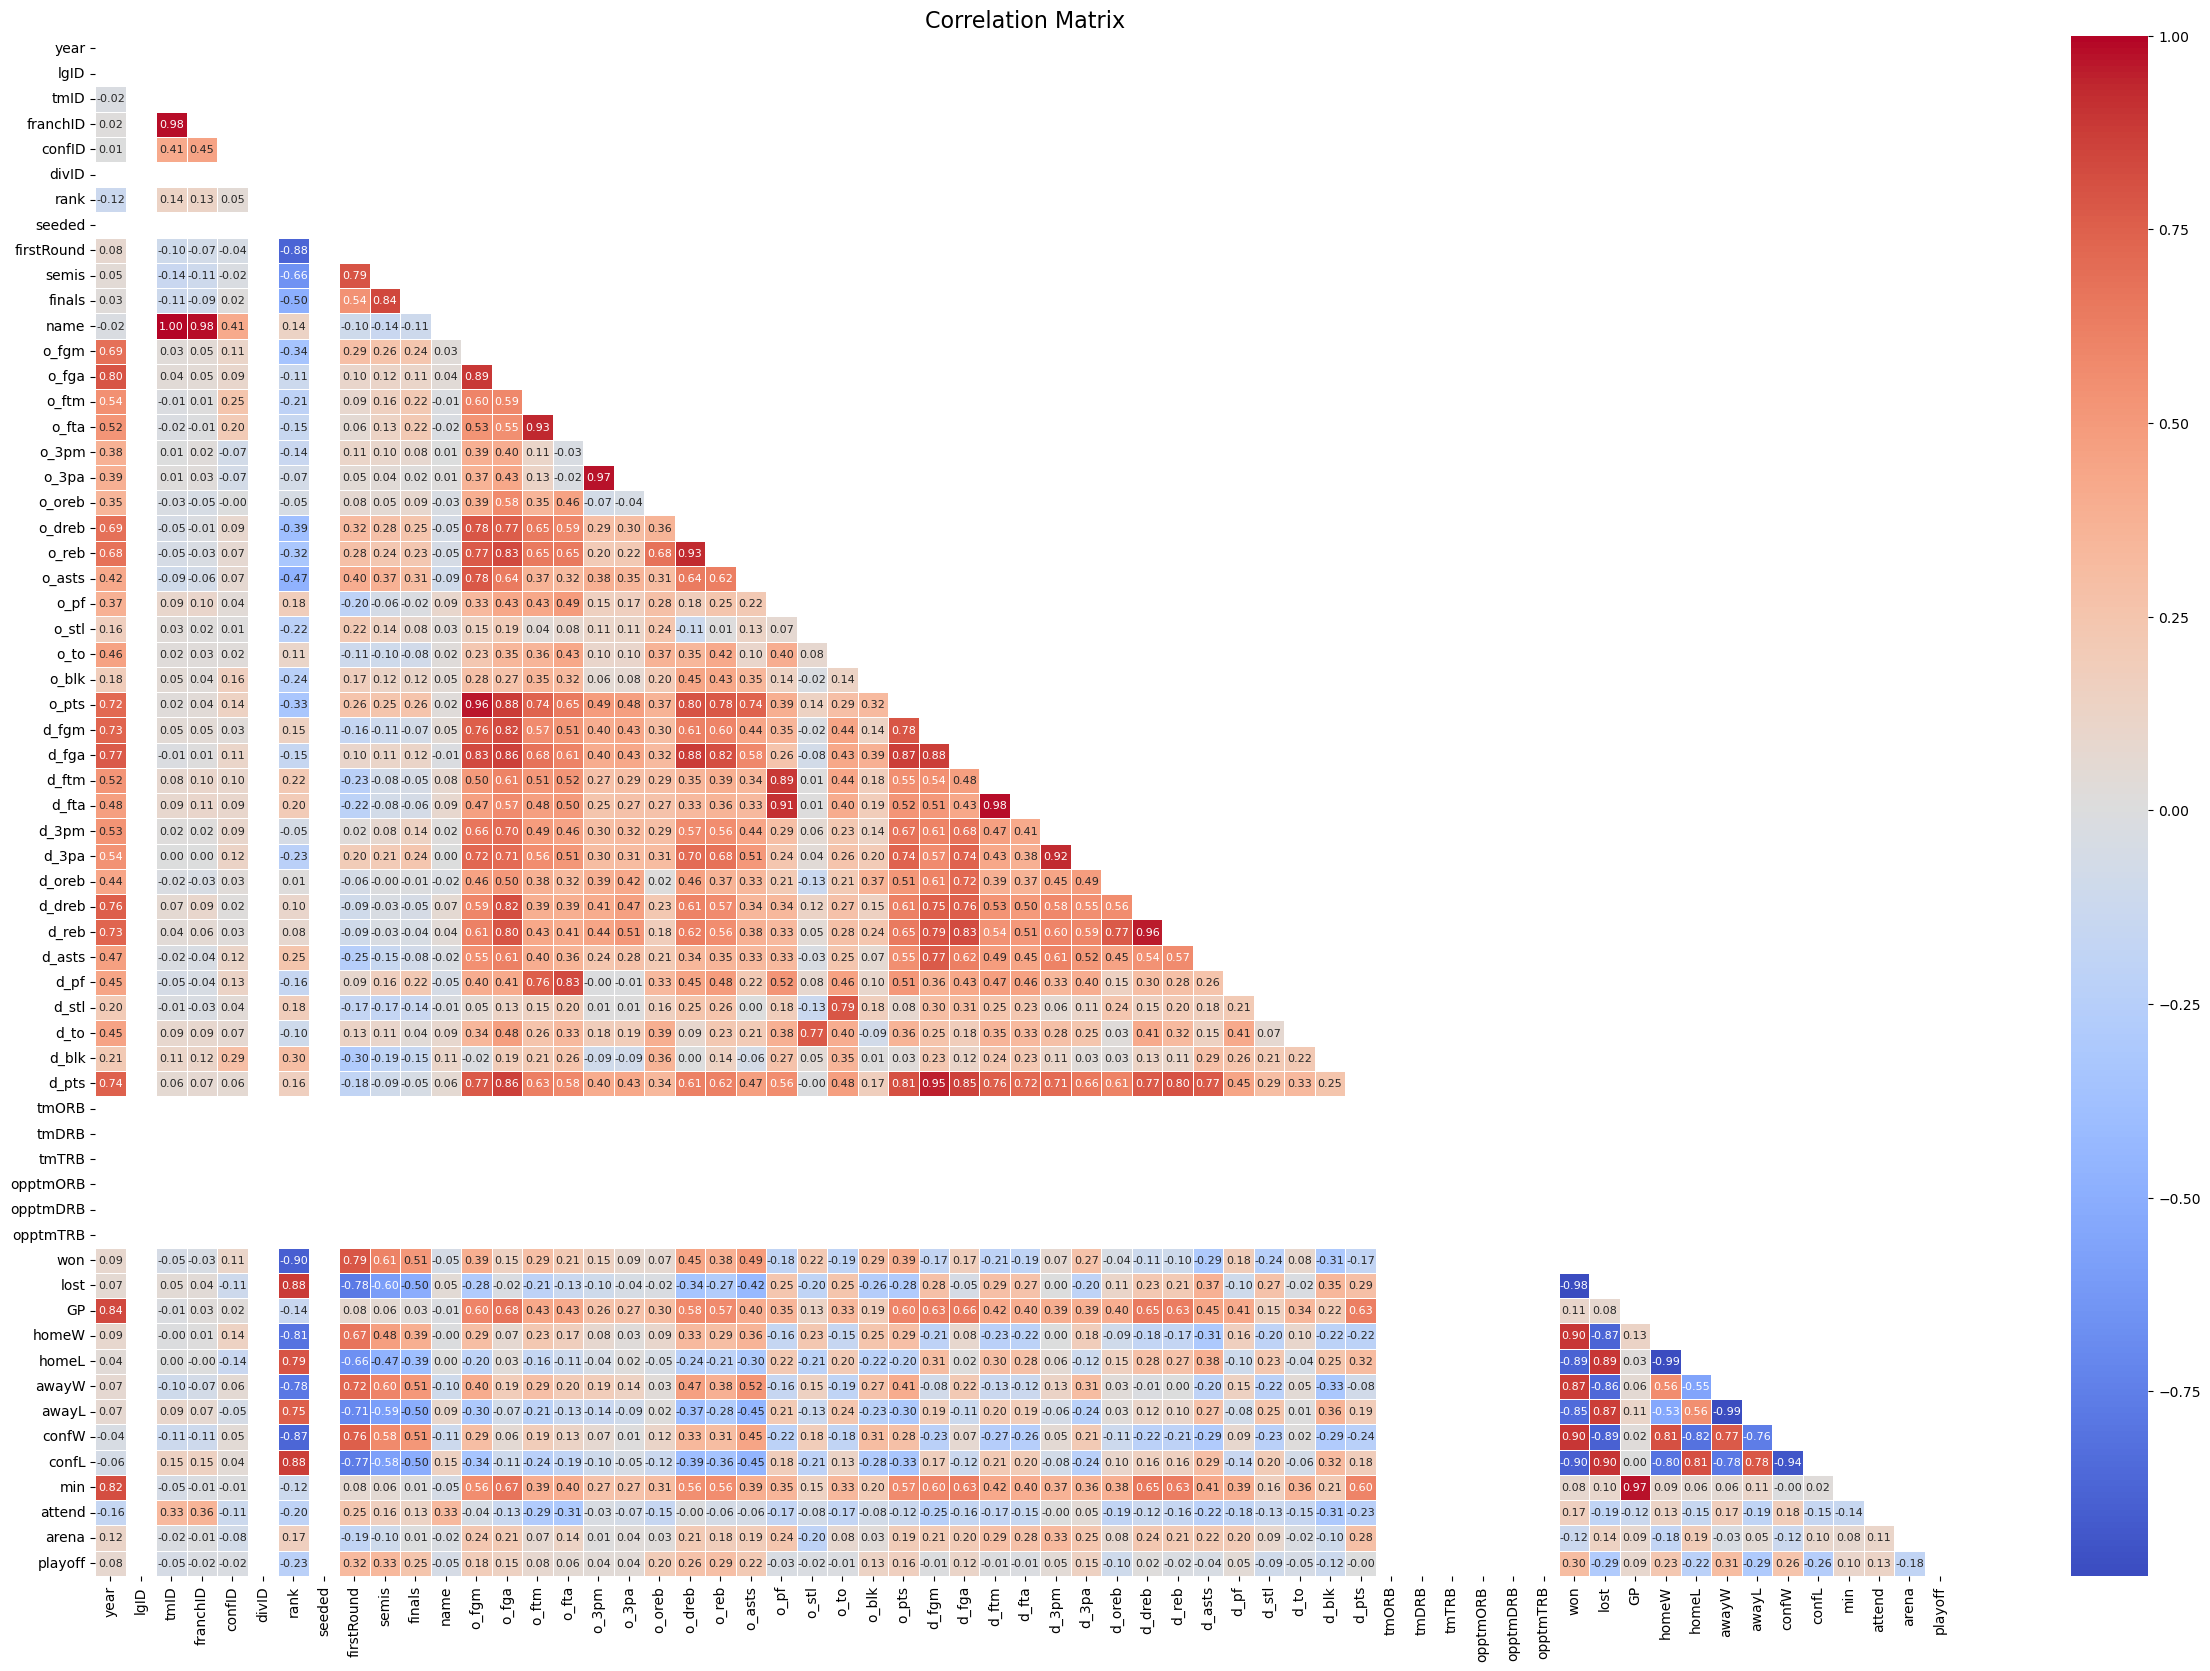

Correlation between target and year: 0.08230252844177124
Correlation between target and lgID: nan
Correlation between target and tmID: -0.05178357638364355
Correlation between target and franchID: -0.020666211177863592
Correlation between target and confID: -0.022078749693891626
Correlation between target and divID: nan
Correlation between target and rank: -0.23447156884008877
Correlation between target and seeded: nan
Correlation between target and firstRound: 0.31711626412189603
Correlation between target and semis: 0.3333984489762754
Correlation between target and finals: 0.2478110294883341
Correlation between target and name: -0.05178357638364355
Correlation between target and o_fgm: 0.18492263007459542
Correlation between target and o_fga: 0.1532758158447968
Correlation between target and o_ftm: 0.07627373558256371
Correlation between target and o_fta: 0.05847217028814615
Correlation between target and o_3pm: 0.03862976852446694
Correlation between target and o_3pa: 0.039844333897

{'year': 0.08230252844177124,
 'lgID': nan,
 'tmID': -0.05178357638364355,
 'franchID': -0.020666211177863592,
 'confID': -0.022078749693891626,
 'divID': nan,
 'rank': -0.23447156884008877,
 'seeded': nan,
 'firstRound': 0.31711626412189603,
 'semis': 0.3333984489762754,
 'finals': 0.2478110294883341,
 'name': -0.05178357638364355,
 'o_fgm': 0.18492263007459542,
 'o_fga': 0.1532758158447968,
 'o_ftm': 0.07627373558256371,
 'o_fta': 0.05847217028814615,
 'o_3pm': 0.03862976852446694,
 'o_3pa': 0.039844333897864334,
 'o_oreb': 0.19723591348627054,
 'o_dreb': 0.2649630650233743,
 'o_reb': 0.2867452917847479,
 'o_asts': 0.21545159323909865,
 'o_pf': -0.03180122331691405,
 'o_stl': -0.017810045979057804,
 'o_to': -0.014034761920402638,
 'o_blk': 0.13389451587659057,
 'o_pts': 0.1622401447944313,
 'd_fgm': -0.007473136711623956,
 'd_fga': 0.11639660605494026,
 'd_ftm': -0.007276259224512964,
 'd_fta': -0.014890420842086709,
 'd_3pm': 0.04634680830833249,
 'd_3pa': 0.14701784645321342,
 'd_o

In [397]:
correlation_matrix(teams)

As we can see, features related to the playoffs are heavily related to whether the team made it to playoffs or not (as expected).  
Some features have no correlation, so they can be eliminated ('lgID', 'divID', 'seeded', 'tmORB', 'tmDRB', 'tmTRB', 'opptmORB', 'opptmDRB', 'opptmTRB')  
Some others like 'name', ' tmID' and 'franchID' are highly related to each other, which means we can delete and leave just one of them. 

In [398]:
teams = teams.drop(columns=['name', 'franchID'])
teams_original = teams_original.drop(columns=['name', 'franchID'])

We can start by reducing the number of feature a team has and make them better features for evaluation, like Points-per-Game for example.

In [399]:
# offensive stats
offensiveFieldGoalPercentageMax = 0
offensiveFieldGoalPercentageMin = 100

offensiveFreeThrowPercentageMax = 0
offensiveFreeThrowPercentageMin = 100

offensiveThreePointPercentageMax = 0
offensiveThreePointPercentageMin = 100

offensiveReboundsPerGameMax = 0
offensiveReboundsPerGameMin = 999

offensiveAssistsPerGameMax = 0
offensiveAssistsPerGameMin = 999

offensivePersonalFoulsPerGameMax = 0
offensivePersonalFoulsPerGameMin = 999

offensiveStealsPerGameMax = 0
offensiveStealsPerGameMin = 999

offensiveTurnoversPerGameMax = 0
offensiveTurnoversPerGameMin = 999

offensiveBlocksPerGameMax = 0
offensiveBlocksPerGameMin = 999

offensivePointsPerGameMax = 0
offensivePointsPerGameMin = 999

In [400]:
# defensive stats
defensiveFieldGoalPercentageMax = 0
defensiveFieldGoalPercentageMin = 100

defensiveFreeThrowPercentageMax = 0
defensiveFreeThrowPercentageMin = 100

defensiveThreePointPercentageMax = 0
defensiveThreePointPercentageMin = 100

defensiveReboundsPerGameMax = 0
defensiveReboundsPerGameMin = 999

defensiveAssistsPerGameMax = 0
defensiveAssistsPerGameMin = 999

defensivePersonalFoulsPerGameMax = 0
defensivePersonalFoulsPerGameMin = 999

defensiveStealsPerGameMax = 0
defensiveStealsPerGameMin = 999

defensiveTurnoversPerGameMax = 0
defensiveTurnoversPerGameMin = 999

defensiveBlocksPerGameMax = 0
defensiveBlocksPerGameMin = 999

defensivePointsPerGameMax = 0
defensivePointsPerGameMin = 999

In [401]:
# global stats
winPercentageMax = 0
winPercentageMin = 100

homeWinPercentageMax = 0
homeWinPercentageMin = 100

awayWinPercentageMax = 0
awayWinPercentageMin = 100

conferenceWinPercentageMax = 0
conferenceWinPercentageMin = 100

attendanceMax = 0
attendanceMin = 9999999

In [402]:
for index, row in teams.iterrows():
    # offensive stats
    offensiveFieldGoalPercentage = (row['o_fgm'] / row['o_fga']) * 100

    if(offensiveFieldGoalPercentage > offensiveFieldGoalPercentageMax):
        offensiveFieldGoalPercentageMax = offensiveFieldGoalPercentage
    if(offensiveFieldGoalPercentage < offensiveFieldGoalPercentageMin):
        offensiveFieldGoalPercentageMin = offensiveFieldGoalPercentage

    offensiveFreeThrowPercentage = (row['o_ftm'] / row['o_fta']) * 100

    if(offensiveFreeThrowPercentage > offensiveFreeThrowPercentageMax):
        offensiveFreeThrowPercentageMax = offensiveFreeThrowPercentage
    if(offensiveFreeThrowPercentage < offensiveFreeThrowPercentageMin):
        offensiveFreeThrowPercentageMin = offensiveFreeThrowPercentage

    offensiveThreePointPercentage = (row['o_3pm'] / row['o_3pa']) * 100

    if(offensiveThreePointPercentage > offensiveThreePointPercentageMax):
        offensiveThreePointPercentageMax = offensiveThreePointPercentage
    if(offensiveThreePointPercentage < offensiveThreePointPercentageMin):
        offensiveThreePointPercentageMin = offensiveThreePointPercentage

    offensiveReboundsPerGame = row['o_reb'] / row['GP']

    if(offensiveReboundsPerGame > offensiveReboundsPerGameMax):
        offensiveReboundsPerGameMax = offensiveReboundsPerGame
    if(offensiveReboundsPerGame < offensiveReboundsPerGameMin):
        offensiveReboundsPerGameMin = offensiveReboundsPerGame

    offensiveAssistsPerGame = row['o_asts'] / row['GP']

    if(offensiveAssistsPerGame > offensiveAssistsPerGameMax):
        offensiveAssistsPerGameMax = offensiveAssistsPerGame
    if(offensiveAssistsPerGame < offensiveAssistsPerGameMin):
        offensiveAssistsPerGameMin = offensiveAssistsPerGame

    offensivePersonalFoulsPerGame = row['o_pf'] / row['GP']

    if(offensivePersonalFoulsPerGame > offensivePersonalFoulsPerGameMax):
        offensivePersonalFoulsPerGameMax = offensivePersonalFoulsPerGame
    if(offensivePersonalFoulsPerGame < offensivePersonalFoulsPerGameMin):
        offensivePersonalFoulsPerGameMin = offensivePersonalFoulsPerGame

    offensiveStealsPerGame = row['o_stl'] / row['GP']

    if(offensiveStealsPerGame > offensiveStealsPerGameMax):
        offensiveStealsPerGameMax = offensiveStealsPerGame
    if(offensiveStealsPerGame < offensiveStealsPerGameMin):
        offensiveStealsPerGameMin = offensiveStealsPerGame

    offensiveTurnoversPerGame = row['o_to'] / row['GP']

    if(offensiveTurnoversPerGame > offensiveTurnoversPerGameMax):
        offensiveTurnoversPerGameMax = offensiveTurnoversPerGame
    if(offensiveTurnoversPerGame < offensiveTurnoversPerGameMin):
        offensiveTurnoversPerGameMin = offensiveTurnoversPerGame

    offensiveBlocksPerGame = row['o_blk'] / row['GP']

    if(offensiveBlocksPerGame > offensiveBlocksPerGameMax):
        offensiveBlocksPerGameMax = offensiveBlocksPerGame
    if(offensiveBlocksPerGame < offensiveBlocksPerGameMin):
        offensiveBlocksPerGameMin = offensiveBlocksPerGame

    offensivePointsPerGame = row['o_pts'] / row['GP']

    if(offensivePointsPerGame > offensivePointsPerGameMax):
        offensivePointsPerGameMax = offensivePointsPerGame
    if(offensivePointsPerGame < offensivePointsPerGameMin):
        offensivePointsPerGameMin = offensivePointsPerGame

    # defensive stats
    defensiveFieldGoalPercentage = (row['d_fgm'] / row['d_fga']) * 100

    if(defensiveFieldGoalPercentage > defensiveFieldGoalPercentageMax):
        defensiveFieldGoalPercentageMax = defensiveFieldGoalPercentage
    if(defensiveFieldGoalPercentage < defensiveFieldGoalPercentageMin):
        defensiveFieldGoalPercentageMin = defensiveFieldGoalPercentage

    defensiveFreeThrowPercentage = (row['d_ftm'] / row['d_fta']) * 100

    if(defensiveFreeThrowPercentage > defensiveFreeThrowPercentageMax):
        defensiveFreeThrowPercentageMax = defensiveFreeThrowPercentage
    if(defensiveFreeThrowPercentage < defensiveFreeThrowPercentageMin):
        defensiveFreeThrowPercentageMin = defensiveFreeThrowPercentage

    defensiveThreePointPercentage = (row['d_3pm'] / row['d_3pa']) * 100

    if(defensiveThreePointPercentage > defensiveThreePointPercentageMax):
        defensiveThreePointPercentageMax = defensiveThreePointPercentage
    if(defensiveThreePointPercentage < defensiveThreePointPercentageMin):
        defensiveThreePointPercentageMin = defensiveThreePointPercentage

    defensiveReboundsPerGame = row['d_reb'] / row['GP']

    if(defensiveReboundsPerGame > defensiveReboundsPerGameMax):
        defensiveReboundsPerGameMax = defensiveReboundsPerGame
    if(defensiveReboundsPerGame < defensiveReboundsPerGameMin):
        defensiveReboundsPerGameMin = defensiveReboundsPerGame

    defensiveAssistsPerGame = row['d_asts'] / row['GP']

    if(defensiveAssistsPerGame > defensiveAssistsPerGameMax):
        defensiveAssistsPerGameMax = defensiveAssistsPerGame
    if(defensiveAssistsPerGame < defensiveAssistsPerGameMin):
        defensiveAssistsPerGameMin = defensiveAssistsPerGame

    defensivePersonalFoulsPerGame = row['d_pf'] / row['GP']

    if(defensivePersonalFoulsPerGame > defensivePersonalFoulsPerGameMax):
        defensivePersonalFoulsPerGameMax = defensivePersonalFoulsPerGame
    if(defensivePersonalFoulsPerGame < defensivePersonalFoulsPerGameMin):
        defensivePersonalFoulsPerGameMin = defensivePersonalFoulsPerGame

    defensiveStealsPerGame = row['d_stl'] / row['GP']

    if(defensiveStealsPerGame > defensiveStealsPerGameMax):
        defensiveStealsPerGameMax = defensiveStealsPerGame
    if(defensiveStealsPerGame < defensiveStealsPerGameMin):
        defensiveStealsPerGameMin = defensiveStealsPerGame

    defensiveTurnoversPerGame = row['d_to'] / row['GP']

    if(defensiveTurnoversPerGame > defensiveTurnoversPerGameMax):
        defensiveTurnoversPerGameMax = defensiveTurnoversPerGame
    if(defensiveTurnoversPerGame < defensiveTurnoversPerGameMin):
        defensiveTurnoversPerGameMin = defensiveTurnoversPerGame

    defensiveBlocksPerGame = row['d_blk'] / row['GP']

    if(defensiveBlocksPerGame > defensiveBlocksPerGameMax):
        defensiveBlocksPerGameMax = defensiveBlocksPerGame
    if(defensiveBlocksPerGame < defensiveBlocksPerGameMin):
        defensiveBlocksPerGameMin = defensiveBlocksPerGame

    defensivePointsPerGame = row['d_pts'] / row['GP']

    if(defensivePointsPerGame > defensivePointsPerGameMax):
        defensivePointsPerGameMax = defensivePointsPerGame
    if(defensivePointsPerGame < defensivePointsPerGameMin):
        defensivePointsPerGameMin = defensivePointsPerGame

    winPercentage = row['won'] / row['GP'] * 100

    if(winPercentage > winPercentageMax):
        winPercentageMax = winPercentage
    if(winPercentage < winPercentageMin):
        winPercentageMin = winPercentage

    homeWinPercentage = row['homeW'] / (row['homeW'] + row['homeL']) * 100

    if(homeWinPercentage > homeWinPercentageMax):
        homeWinPercentageMax = homeWinPercentage    
    if(homeWinPercentage < homeWinPercentageMin):
        homeWinPercentageMin = homeWinPercentage

    awayWinPercentage = row['awayW'] / (row['awayW'] + row['awayL']) * 100

    if(awayWinPercentage > awayWinPercentageMax):
        awayWinPercentageMax = awayWinPercentage
    if(awayWinPercentage < awayWinPercentageMin):
        awayWinPercentageMin = awayWinPercentage

    conferenceWinPercentage = row['confW'] / (row['confW'] + row['confL']) * 100

    if(conferenceWinPercentage > conferenceWinPercentageMax):
        conferenceWinPercentageMax = conferenceWinPercentage
    if(conferenceWinPercentage < conferenceWinPercentageMin):
        conferenceWinPercentageMin = conferenceWinPercentage

    if(row['attend'] > attendanceMax):
        attendanceMax = row['attend']
    if(row['attend'] < attendanceMin):
        attendanceMin = row['attend']

In [403]:
print("offensiveFieldGoalPercentageMax: ", offensiveFieldGoalPercentageMax)
print("offensiveFieldGoalPercentageMin: ", offensiveFieldGoalPercentageMin)
print("offensiveFreeThrowPercentageMax: ", offensiveFreeThrowPercentageMax)
print("offensiveFreeThrowPercentageMin: ", offensiveFreeThrowPercentageMin)
print("offensiveThreePointPercentageMax: ", offensiveThreePointPercentageMax)
print("offensiveThreePointPercentageMin: ", offensiveThreePointPercentageMin)
print("offensiveReboundsPerGameMax: ", offensiveReboundsPerGameMax)
print("offensiveReboundsPerGameMin: ", offensiveReboundsPerGameMin)
print("offensiveAssistsPerGameMax: ", offensiveAssistsPerGameMax)
print("offensiveAssistsPerGameMin: ", offensiveAssistsPerGameMin)
print("offensivePersonalFoulsPerGameMax: ", offensivePersonalFoulsPerGameMax)
print("offensivePersonalFoulsPerGameMin: ", offensivePersonalFoulsPerGameMin)
print("offensiveStealsPerGameMax: ", offensiveStealsPerGameMax)
print("offensiveStealsPerGameMin: ", offensiveStealsPerGameMin)
print("offensiveTurnoversPerGameMax: ", offensiveTurnoversPerGameMax)
print("offensiveTurnoversPerGameMin: ", offensiveTurnoversPerGameMin)
print("offensiveBlocksPerGameMax: ", offensiveBlocksPerGameMax)
print("offensiveBlocksPerGameMin: ", offensiveBlocksPerGameMin)
print("offensivePointsPerGameMax: ", offensivePointsPerGameMax)
print("offensivePointsPerGameMin: ", offensivePointsPerGameMin)

offensiveFieldGoalPercentageMax:  47.04329461457233
offensiveFieldGoalPercentageMin:  36.471251409244644
offensiveFreeThrowPercentageMax:  83.05304010349288
offensiveFreeThrowPercentageMin:  65.76227390180878
offensiveThreePointPercentageMax:  40.03795066413662
offensiveThreePointPercentageMin:  27.419354838709676
offensiveReboundsPerGameMax:  38.55882352941177
offensiveReboundsPerGameMin:  24.78125
offensiveAssistsPerGameMax:  20.08823529411765
offensiveAssistsPerGameMin:  12.1875
offensivePersonalFoulsPerGameMax:  23.78125
offensivePersonalFoulsPerGameMin:  14.411764705882353
offensiveStealsPerGameMax:  10.411764705882353
offensiveStealsPerGameMin:  5.5
offensiveTurnoversPerGameMax:  18.735294117647058
offensiveTurnoversPerGameMin:  12.470588235294118
offensiveBlocksPerGameMax:  6.352941176470588
offensiveBlocksPerGameMin:  1.96875
offensivePointsPerGameMax:  88.97058823529412
offensivePointsPerGameMin:  56.9375


In [404]:
print("defensiveFieldGoalPercentageMax: ", defensiveFieldGoalPercentageMax)
print("defensiveFieldGoalPercentageMin: ", defensiveFieldGoalPercentageMin)
print("defensiveFreeThrowPercentageMax: ", defensiveFreeThrowPercentageMax)
print("defensiveFreeThrowPercentageMin: ", defensiveFreeThrowPercentageMin)
print("defensiveThreePointPercentageMax: ", defensiveThreePointPercentageMax)
print("defensiveThreePointPercentageMin: ", defensiveThreePointPercentageMin)
print("defensiveReboundsPerGameMax: ", defensiveReboundsPerGameMax)
print("defensiveReboundsPerGameMin: ", defensiveReboundsPerGameMin)
print("defensiveAssistsPerGameMax: ", defensiveAssistsPerGameMax)
print("defensiveAssistsPerGameMin: ", defensiveAssistsPerGameMin)
print("defensivePersonalFoulsPerGameMax: ", defensivePersonalFoulsPerGameMax)
print("defensivePersonalFoulsPerGameMin: ", defensivePersonalFoulsPerGameMin)
print("defensiveStealsPerGameMax: ", defensiveStealsPerGameMax)
print("defensiveStealsPerGameMin: ", defensiveStealsPerGameMin)
print("defensiveTurnoversPerGameMax: ", defensiveTurnoversPerGameMax)
print("defensiveTurnoversPerGameMin: ", defensiveTurnoversPerGameMin)
print("defensiveBlocksPerGameMax: ", defensiveBlocksPerGameMax)
print("defensiveBlocksPerGameMin: ", defensiveBlocksPerGameMin)
print("defensivePointsPerGameMax: ", defensivePointsPerGameMax)
print("defensivePointsPerGameMin: ", defensivePointsPerGameMin)

defensiveFieldGoalPercentageMax:  46.16222101252042
defensiveFieldGoalPercentageMin:  37.5
defensiveFreeThrowPercentageMax:  81.56996587030717
defensiveFreeThrowPercentageMin:  68.82882882882882
defensiveThreePointPercentageMax:  39.948453608247426
defensiveThreePointPercentageMin:  27.61904761904762
defensiveReboundsPerGameMax:  40.88235294117647
defensiveReboundsPerGameMin:  27.28125
defensiveAssistsPerGameMax:  20.11764705882353
defensiveAssistsPerGameMin:  12.125
defensivePersonalFoulsPerGameMax:  22.78125
defensivePersonalFoulsPerGameMin:  16.61764705882353
defensiveStealsPerGameMax:  9.794117647058824
defensiveStealsPerGameMin:  5.794117647058823
defensiveTurnoversPerGameMax:  19.08823529411765
defensiveTurnoversPerGameMin:  12.088235294117647
defensiveBlocksPerGameMax:  6.0588235294117645
defensiveBlocksPerGameMin:  2.21875
defensivePointsPerGameMax:  88.5
defensivePointsPerGameMin:  55.875


In [405]:
# global stats
print("winPercentageMax: ", winPercentageMax)
print("winPercentageMin: ", winPercentageMin)
print("homeWinPercentageMax: ", homeWinPercentageMax)
print("homeWinPercentageMin: ", homeWinPercentageMin)
print("awayWinPercentageMax: ", awayWinPercentageMax)
print("awayWinPercentageMin: ", awayWinPercentageMin)
print("conferenceWinPercentageMax: ", conferenceWinPercentageMax)
print("conferenceWinPercentageMin: ", conferenceWinPercentageMin)
print("attendanceMax: ", attendanceMax)
print("attendanceMin: ", attendanceMin)

winPercentageMax:  87.5
winPercentageMin:  11.76470588235294
homeWinPercentageMax:  100.0
homeWinPercentageMin:  5.88235294117647
awayWinPercentageMax:  81.25
awayWinPercentageMin:  5.88235294117647
conferenceWinPercentageMax:  90.47619047619048
conferenceWinPercentageMin:  10.0
attendanceMax:  259237.0
attendanceMin:  57635.0


In [406]:
def team_power_ranking(team): 

    # offensive stats
    offensiveFieldGoalPercentage = (team['o_fgm'] / team['o_fga']) * 100
    offensiveFieldGoalPercentage = (offensiveFieldGoalPercentage - offensiveFieldGoalPercentageMin) / (offensiveFieldGoalPercentageMax - offensiveFieldGoalPercentageMin) * 100

    offensiveFreeThrowPercentage = (team['o_ftm'] / team['o_fta']) * 100
    offensiveFreeThrowPercentage = (offensiveFreeThrowPercentage - offensiveFreeThrowPercentageMin) / (offensiveFreeThrowPercentageMax - offensiveFreeThrowPercentageMin) * 100

    offensiveThreePointPercentage = (team['o_3pm'] / team['o_3pa']) * 100
    offensiveThreePointPercentage = (offensiveThreePointPercentage - offensiveThreePointPercentageMin) / (offensiveThreePointPercentageMax - offensiveThreePointPercentageMin) * 100

    offensiveReboundsPerGame = team['o_reb'] / team['GP']
    offensiveReboundsPerGame = (offensiveReboundsPerGame - offensiveReboundsPerGameMin) / (offensiveReboundsPerGameMax - offensiveReboundsPerGameMin) * 100

    offensiveAssistsPerGame = team['o_asts'] / team['GP']
    offensiveAssistsPerGame = (offensiveAssistsPerGame - offensiveAssistsPerGameMin) / (offensiveAssistsPerGameMax - offensiveAssistsPerGameMin) * 100

    offensivePersonalFoulsPerGame = team['o_pf'] / team['GP']
    offensivePersonalFoulsPerGame = (offensivePersonalFoulsPerGame - offensivePersonalFoulsPerGameMin) / (offensivePersonalFoulsPerGameMax - offensivePersonalFoulsPerGameMin) * 100

    offensiveStealsPerGame = team['o_stl'] / team['GP']
    offensiveStealsPerGame = (offensiveStealsPerGame - offensiveStealsPerGameMin) / (offensiveStealsPerGameMax - offensiveStealsPerGameMin) * 100

    offensiveTurnoversPerGame = team['o_to'] / team['GP']
    offensiveTurnoversPerGame = (offensiveTurnoversPerGame - offensiveTurnoversPerGameMin) / (offensiveTurnoversPerGameMax - offensiveTurnoversPerGameMin) * 100

    offensiveBlocksPerGame = team['o_blk'] / team['GP']
    offensiveBlocksPerGame = (offensiveBlocksPerGame - offensiveBlocksPerGameMin) / (offensiveBlocksPerGameMax - offensiveBlocksPerGameMin) * 100

    offensivePointsPerGame = team['o_pts'] / team['GP']
    offensivePointsPerGame = (offensivePointsPerGame - offensivePointsPerGameMin) / (offensivePointsPerGameMax - offensivePointsPerGameMin) * 100

    # defensive stats
    defensiveFieldGoalPercentage = (team['d_fgm'] / team['d_fga']) * 100
    defensiveFieldGoalPercentage = (defensiveFieldGoalPercentage - defensiveFieldGoalPercentageMin) / (defensiveFieldGoalPercentageMax - defensiveFieldGoalPercentageMin) * 100

    defensiveFreeThrowPercentage = (team['d_ftm'] / team['d_fta']) * 100
    defensiveFreeThrowPercentage = (defensiveFreeThrowPercentage - defensiveFreeThrowPercentageMin) / (defensiveFreeThrowPercentageMax - defensiveFreeThrowPercentageMin) * 100

    defensiveThreePointPercentage = (team['d_3pm'] / team['d_3pa']) * 100
    defensiveThreePointPercentage = (defensiveThreePointPercentage - defensiveThreePointPercentageMin) / (defensiveThreePointPercentageMax - defensiveThreePointPercentageMin) * 100

    defensiveReboundsPerGame = team['d_reb'] / team['GP']
    defensiveReboundsPerGame = (defensiveReboundsPerGame - defensiveReboundsPerGameMin) / (defensiveReboundsPerGameMax - defensiveReboundsPerGameMin) * 100

    defensiveAssistsPerGame = team['d_asts'] / team['GP']
    defensiveAssistsPerGame = (defensiveAssistsPerGame - defensiveAssistsPerGameMin) / (defensiveAssistsPerGameMax - defensiveAssistsPerGameMin) * 100

    defensivePersonalFoulsPerGame = team['d_pf'] / team['GP']
    defensivePersonalFoulsPerGame = (defensivePersonalFoulsPerGame - defensivePersonalFoulsPerGameMin) / (defensivePersonalFoulsPerGameMax - defensivePersonalFoulsPerGameMin) * 100

    defensiveStealsPerGame = team['d_stl'] / team['GP']
    defensiveStealsPerGame = (defensiveStealsPerGame - defensiveStealsPerGameMin) / (defensiveStealsPerGameMax - defensiveStealsPerGameMin) * 100

    defensiveTurnoversPerGame = team['d_to'] / team['GP']
    defensiveTurnoversPerGame = (defensiveTurnoversPerGame - defensiveTurnoversPerGameMin) / (defensiveTurnoversPerGameMax - defensiveTurnoversPerGameMin) * 100

    defensiveBlocksPerGame = team['d_blk'] / team['GP']
    defensiveBlocksPerGame = (defensiveBlocksPerGame - defensiveBlocksPerGameMin) / (defensiveBlocksPerGameMax - defensiveBlocksPerGameMin) * 100

    defensivePointsPerGame = team['d_pts'] / team['GP']
    defensivePointsPerGame = (defensivePointsPerGame - defensivePointsPerGameMin) / (defensivePointsPerGameMax - defensivePointsPerGameMin) * 100

    # global stats
    winPercentage = team['won'] / team['GP'] * 100
    winPercentage = (winPercentage - winPercentageMin) / (winPercentageMax - winPercentageMin) * 100

    homeWinPercentage = team['homeW'] / (team['homeW'] + team['homeL']) * 100
    homeWinPercentage = (homeWinPercentage - homeWinPercentageMin) / (homeWinPercentageMax - homeWinPercentageMin) * 100

    awayWinPercentage = team['awayW'] / (team['awayW'] + team['awayL']) * 100
    awayWinPercentage = (awayWinPercentage - awayWinPercentageMin) / (awayWinPercentageMax - awayWinPercentageMin) * 100

    conferenceWinPercentage = team['confW'] / (team['confW'] + team['confL']) * 100
    conferenceWinPercentage = (conferenceWinPercentage - conferenceWinPercentageMin) / (conferenceWinPercentageMax - conferenceWinPercentageMin) * 100

    attendance = (team['attend'] - attendanceMin) / (attendanceMax - attendanceMin) * 100

    relevantFeatures = [ offensiveFieldGoalPercentage, offensiveFreeThrowPercentage, offensiveThreePointPercentage, offensiveReboundsPerGame, offensiveAssistsPerGame, 
                        offensivePersonalFoulsPerGame, offensiveStealsPerGame, offensiveTurnoversPerGame, offensiveBlocksPerGame, offensivePointsPerGame, 
                        defensiveFieldGoalPercentage, defensiveFreeThrowPercentage, defensiveThreePointPercentage, defensiveReboundsPerGame, defensiveAssistsPerGame, 
                        defensivePersonalFoulsPerGame, defensiveStealsPerGame, defensiveTurnoversPerGame, defensiveBlocksPerGame, defensivePointsPerGame, winPercentage, 
                        homeWinPercentage, awayWinPercentage, conferenceWinPercentage, attendance ]
    
    powerRankingAcummulator = 0
    numberOfFeatures = len(relevantFeatures)
    averageFeatureWeight = 1 / numberOfFeatures

    for feature in relevantFeatures:
        powerRankingAcummulator += feature * averageFeatureWeight

    return [powerRankingAcummulator] + relevantFeatures

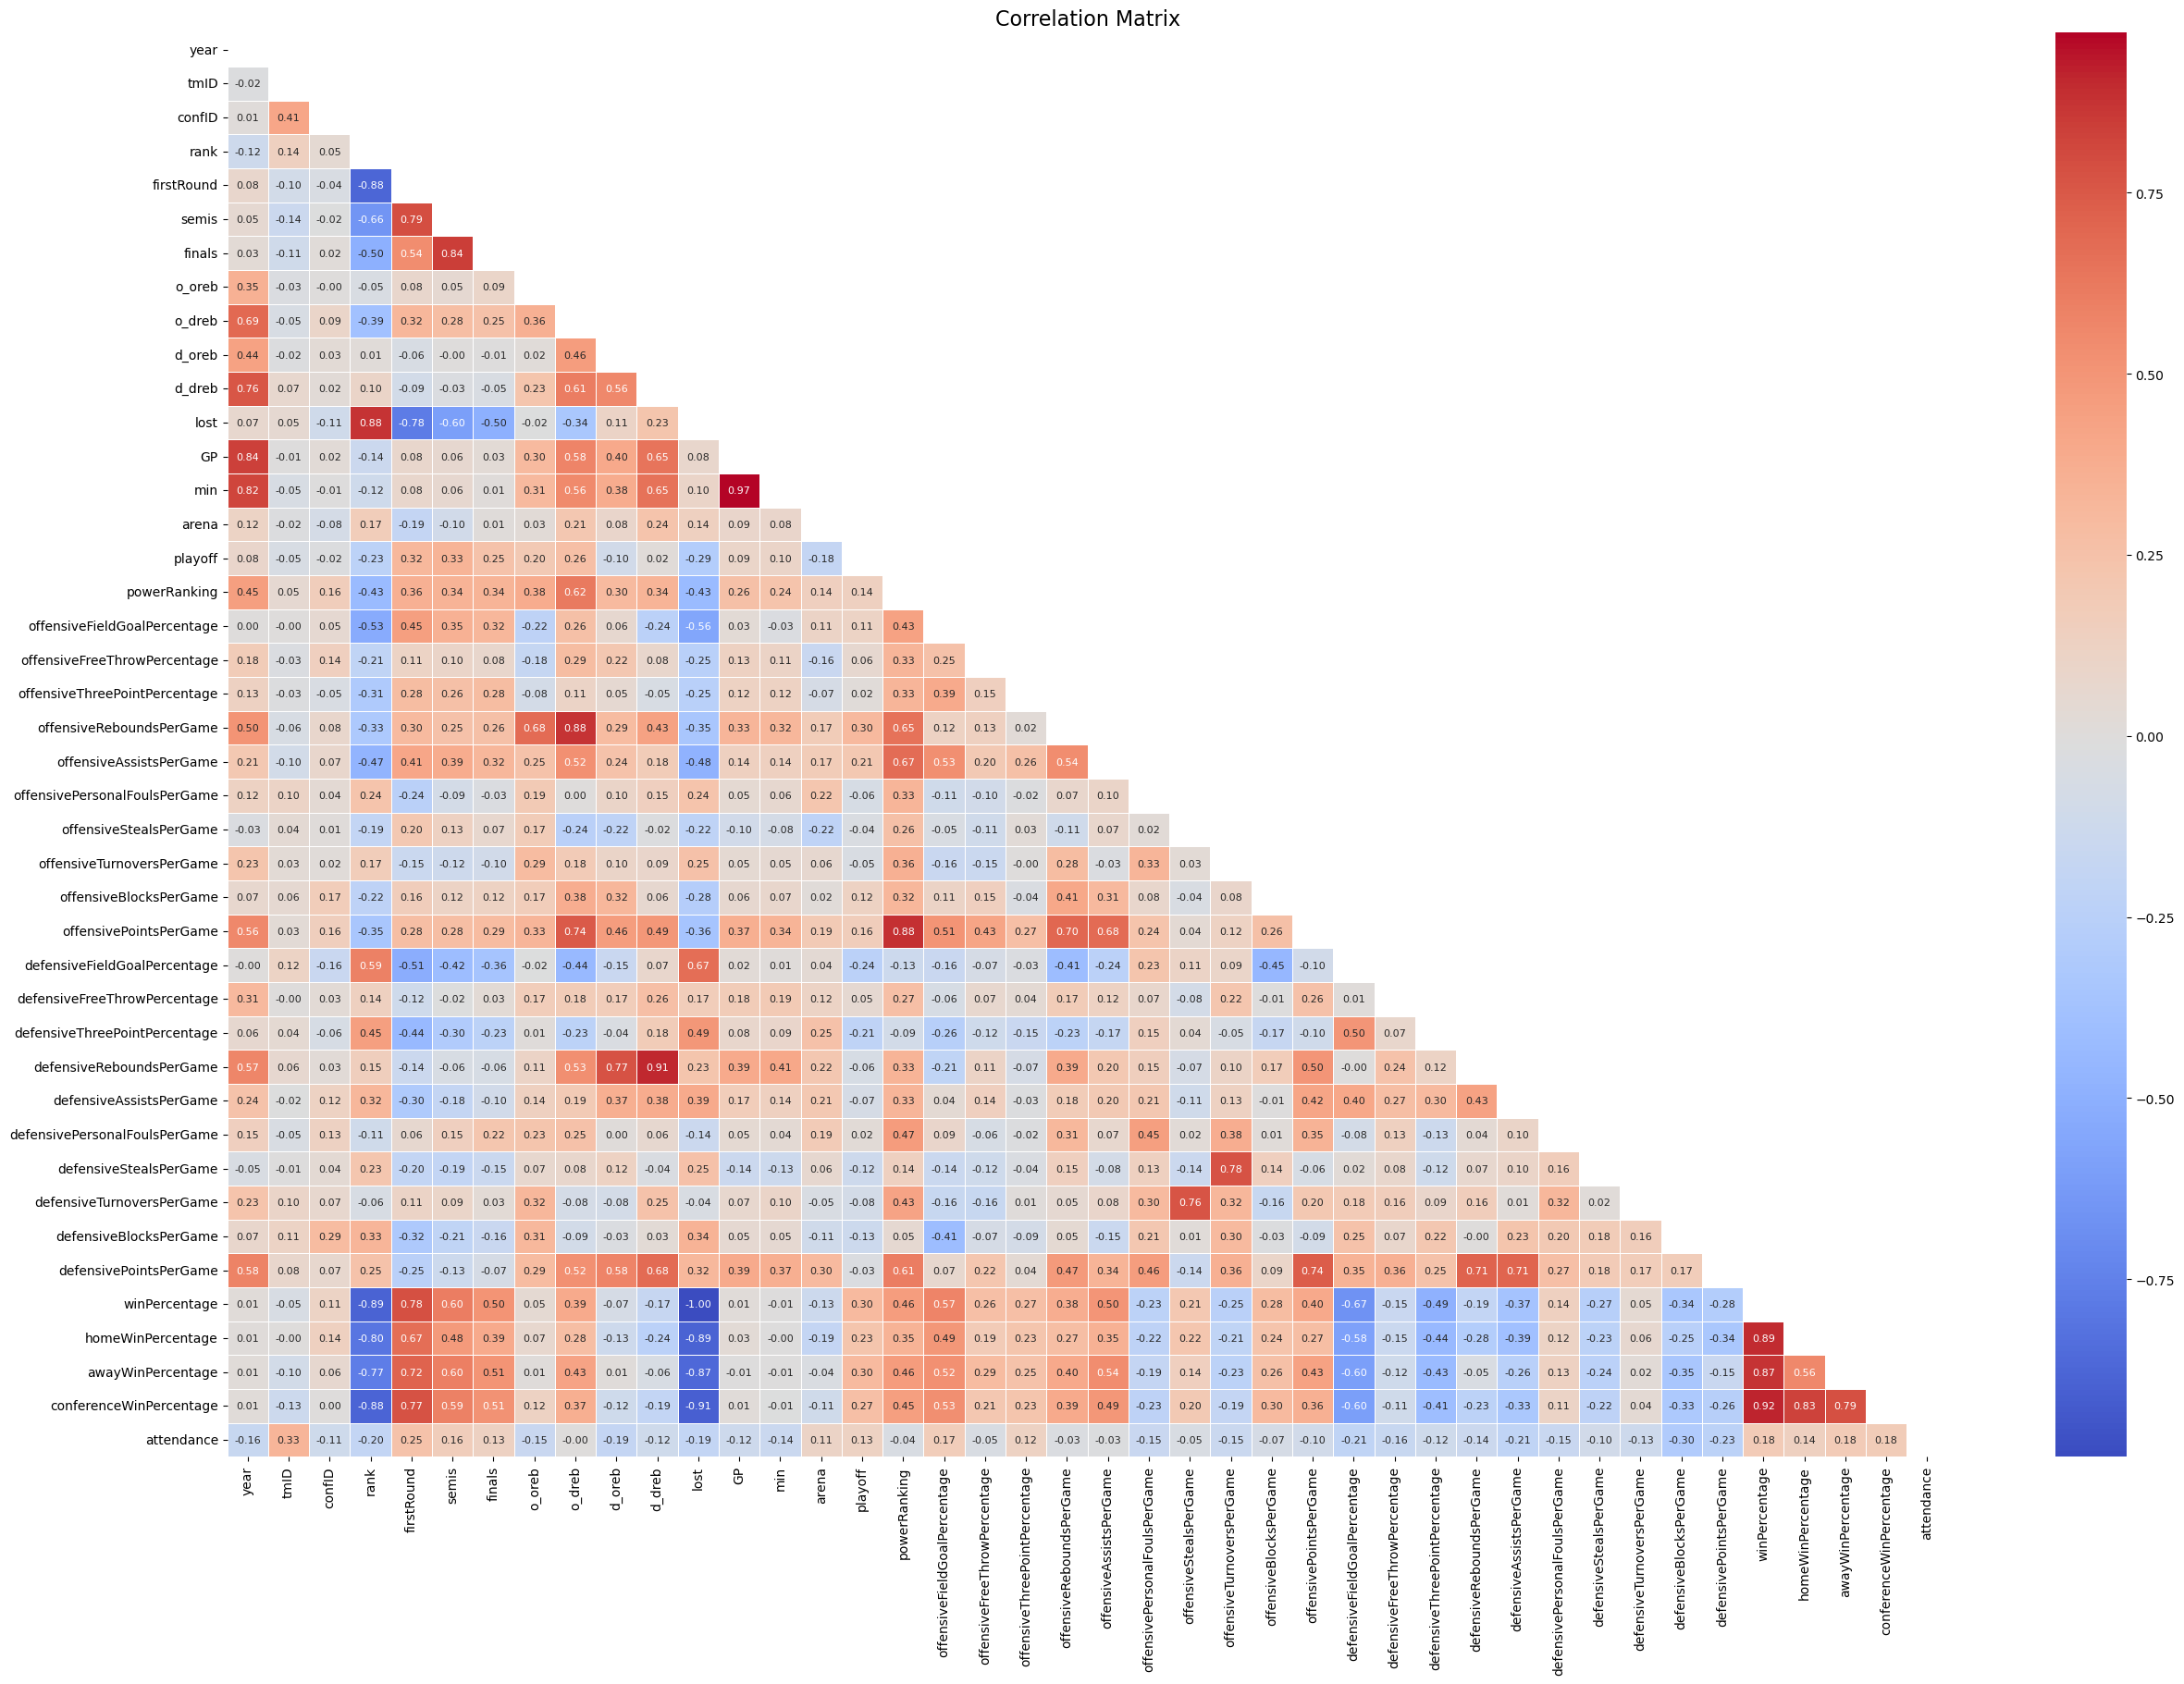

Correlation between target and year: 0.08230252844177124
Correlation between target and tmID: -0.05178357638364355
Correlation between target and confID: -0.022078749693891626
Correlation between target and rank: -0.23447156884008877
Correlation between target and firstRound: 0.31711626412189603
Correlation between target and semis: 0.3333984489762754
Correlation between target and finals: 0.2478110294883341
Correlation between target and o_oreb: 0.19723591348627054
Correlation between target and o_dreb: 0.2649630650233743
Correlation between target and d_oreb: -0.10232115132727775
Correlation between target and d_dreb: 0.01692793633446554
Correlation between target and lost: -0.28838437989404525
Correlation between target and GP: 0.09020678776091365
Correlation between target and min: 0.09959604664638144
Correlation between target and arena: -0.18191310143996453
Correlation between target and playoff: 1.0
Correlation between target and powerRanking: 0.13920238464348525
Correlation bet

In [407]:
team1 = teams.copy()

for index, team in team1.iterrows(): 
    powerRanking = team_power_ranking(team)

    team1.at[index, 'powerRanking'] = powerRanking[0]
    team1.at[index, 'offensiveFieldGoalPercentage'] = powerRanking[1]
    team1.at[index, 'offensiveFreeThrowPercentage'] = powerRanking[2]
    team1.at[index, 'offensiveThreePointPercentage'] = powerRanking[3]
    team1.at[index, 'offensiveReboundsPerGame'] = powerRanking[4]
    team1.at[index, 'offensiveAssistsPerGame'] = powerRanking[5]
    team1.at[index, 'offensivePersonalFoulsPerGame'] = powerRanking[6]
    team1.at[index, 'offensiveStealsPerGame'] = powerRanking[7]
    team1.at[index, 'offensiveTurnoversPerGame'] = powerRanking[8]
    team1.at[index, 'offensiveBlocksPerGame'] = powerRanking[9]
    team1.at[index, 'offensivePointsPerGame'] = powerRanking[10]
    team1.at[index, 'defensiveFieldGoalPercentage'] = powerRanking[11]
    team1.at[index, 'defensiveFreeThrowPercentage'] = powerRanking[12]
    team1.at[index, 'defensiveThreePointPercentage'] = powerRanking[13]
    team1.at[index, 'defensiveReboundsPerGame'] = powerRanking[14]
    team1.at[index, 'defensiveAssistsPerGame'] = powerRanking[15]
    team1.at[index, 'defensivePersonalFoulsPerGame'] = powerRanking[16]
    team1.at[index, 'defensiveStealsPerGame'] = powerRanking[17]
    team1.at[index, 'defensiveTurnoversPerGame'] = powerRanking[18]
    team1.at[index, 'defensiveBlocksPerGame'] = powerRanking[19]
    team1.at[index, 'defensivePointsPerGame'] = powerRanking[20]
    team1.at[index, 'winPercentage'] = powerRanking[21]
    team1.at[index, 'homeWinPercentage'] = powerRanking[22]
    team1.at[index, 'awayWinPercentage'] = powerRanking[23]
    team1.at[index, 'conferenceWinPercentage'] = powerRanking[24]
    team1.at[index, 'attendance'] = powerRanking[25]


team1 = team1.drop(columns=['o_fgm', 'o_fga', 'o_ftm', 'o_fta', 'o_3pm', 'o_3pa', 'o_reb', 'o_asts', 'o_pf', 'o_stl', 'o_to', 'o_blk', 'o_pts', 'd_fgm', 'd_fga', 'd_ftm', 'd_fta', 'd_3pm', 'd_3pa', 'd_reb', 'd_asts', 'd_pf', 'd_stl', 'd_to', 'd_blk', 'd_pts', 'won', 'homeW', 'homeL', 'awayW', 'awayL', 'confW', 'confL', 'attend'])
team1 = team1.drop(columns=['lgID', 'divID', 'seeded', 'tmORB', 'tmDRB', 'tmTRB', 'opptmORB', 'opptmDRB', 'opptmTRB'])
team1.to_csv('team1.csv', index=False)

features_weight = correlation_matrix(team1)

Based on the correlation matrix values, lets refine team power ranking and observe the difference. 

In [408]:
def team_power_ranking_2(team, variables_weight): 

    # offensive stats
    offensiveFieldGoalPercentage = (team['o_fgm'] / team['o_fga']) * 100
    offensiveFieldGoalPercentage = (offensiveFieldGoalPercentage - offensiveFieldGoalPercentageMin) / (offensiveFieldGoalPercentageMax - offensiveFieldGoalPercentageMin) * 100

    offensiveFreeThrowPercentage = (team['o_ftm'] / team['o_fta']) * 100
    offensiveFreeThrowPercentage = (offensiveFreeThrowPercentage - offensiveFreeThrowPercentageMin) / (offensiveFreeThrowPercentageMax - offensiveFreeThrowPercentageMin) * 100

    offensiveThreePointPercentage = (team['o_3pm'] / team['o_3pa']) * 100
    offensiveThreePointPercentage = (offensiveThreePointPercentage - offensiveThreePointPercentageMin) / (offensiveThreePointPercentageMax - offensiveThreePointPercentageMin) * 100

    offensiveReboundsPerGame = team['o_reb'] / team['GP']
    offensiveReboundsPerGame = (offensiveReboundsPerGame - offensiveReboundsPerGameMin) / (offensiveReboundsPerGameMax - offensiveReboundsPerGameMin) * 100

    offensiveAssistsPerGame = team['o_asts'] / team['GP']
    offensiveAssistsPerGame = (offensiveAssistsPerGame - offensiveAssistsPerGameMin) / (offensiveAssistsPerGameMax - offensiveAssistsPerGameMin) * 100

    offensivePersonalFoulsPerGame = team['o_pf'] / team['GP']
    offensivePersonalFoulsPerGame = (offensivePersonalFoulsPerGame - offensivePersonalFoulsPerGameMin) / (offensivePersonalFoulsPerGameMax - offensivePersonalFoulsPerGameMin) * 100

    offensiveStealsPerGame = team['o_stl'] / team['GP']
    offensiveStealsPerGame = (offensiveStealsPerGame - offensiveStealsPerGameMin) / (offensiveStealsPerGameMax - offensiveStealsPerGameMin) * 100

    offensiveTurnoversPerGame = team['o_to'] / team['GP']
    offensiveTurnoversPerGame = (offensiveTurnoversPerGame - offensiveTurnoversPerGameMin) / (offensiveTurnoversPerGameMax - offensiveTurnoversPerGameMin) * 100

    offensiveBlocksPerGame = team['o_blk'] / team['GP']
    offensiveBlocksPerGame = (offensiveBlocksPerGame - offensiveBlocksPerGameMin) / (offensiveBlocksPerGameMax - offensiveBlocksPerGameMin) * 100

    offensivePointsPerGame = team['o_pts'] / team['GP']
    offensivePointsPerGame = (offensivePointsPerGame - offensivePointsPerGameMin) / (offensivePointsPerGameMax - offensivePointsPerGameMin) * 100

    # defensive stats
    defensiveFieldGoalPercentage = (team['d_fgm'] / team['d_fga']) * 100
    defensiveFieldGoalPercentage = (defensiveFieldGoalPercentage - defensiveFieldGoalPercentageMin) / (defensiveFieldGoalPercentageMax - defensiveFieldGoalPercentageMin) * 100

    defensiveFreeThrowPercentage = (team['d_ftm'] / team['d_fta']) * 100
    defensiveFreeThrowPercentage = (defensiveFreeThrowPercentage - defensiveFreeThrowPercentageMin) / (defensiveFreeThrowPercentageMax - defensiveFreeThrowPercentageMin) * 100

    defensiveThreePointPercentage = (team['d_3pm'] / team['d_3pa']) * 100
    defensiveThreePointPercentage = (defensiveThreePointPercentage - defensiveThreePointPercentageMin) / (defensiveThreePointPercentageMax - defensiveThreePointPercentageMin) * 100

    defensiveReboundsPerGame = team['d_reb'] / team['GP']
    defensiveReboundsPerGame = (defensiveReboundsPerGame - defensiveReboundsPerGameMin) / (defensiveReboundsPerGameMax - defensiveReboundsPerGameMin) * 100

    defensiveAssistsPerGame = team['d_asts'] / team['GP']
    defensiveAssistsPerGame = (defensiveAssistsPerGame - defensiveAssistsPerGameMin) / (defensiveAssistsPerGameMax - defensiveAssistsPerGameMin) * 100

    defensivePersonalFoulsPerGame = team['d_pf'] / team['GP']
    defensivePersonalFoulsPerGame = (defensivePersonalFoulsPerGame - defensivePersonalFoulsPerGameMin) / (defensivePersonalFoulsPerGameMax - defensivePersonalFoulsPerGameMin) * 100

    defensiveStealsPerGame = team['d_stl'] / team['GP']
    defensiveStealsPerGame = (defensiveStealsPerGame - defensiveStealsPerGameMin) / (defensiveStealsPerGameMax - defensiveStealsPerGameMin) * 100

    defensiveTurnoversPerGame = team['d_to'] / team['GP']
    defensiveTurnoversPerGame = (defensiveTurnoversPerGame - defensiveTurnoversPerGameMin) / (defensiveTurnoversPerGameMax - defensiveTurnoversPerGameMin) * 100

    defensiveBlocksPerGame = team['d_blk'] / team['GP']
    defensiveBlocksPerGame = (defensiveBlocksPerGame - defensiveBlocksPerGameMin) / (defensiveBlocksPerGameMax - defensiveBlocksPerGameMin) * 100

    defensivePointsPerGame = team['d_pts'] / team['GP']
    defensivePointsPerGame = (defensivePointsPerGame - defensivePointsPerGameMin) / (defensivePointsPerGameMax - defensivePointsPerGameMin) * 100

    # global stats
    winPercentage = team['won'] / team['GP'] * 100
    winPercentage = (winPercentage - winPercentageMin) / (winPercentageMax - winPercentageMin) * 100

    homeWinPercentage = team['homeW'] / (team['homeW'] + team['homeL']) * 100
    homeWinPercentage = (homeWinPercentage - homeWinPercentageMin) / (homeWinPercentageMax - homeWinPercentageMin) * 100

    awayWinPercentage = team['awayW'] / (team['awayW'] + team['awayL']) * 100
    awayWinPercentage = (awayWinPercentage - awayWinPercentageMin) / (awayWinPercentageMax - awayWinPercentageMin) * 100

    conferenceWinPercentage = team['confW'] / (team['confW'] + team['confL']) * 100
    conferenceWinPercentage = (conferenceWinPercentage - conferenceWinPercentageMin) / (conferenceWinPercentageMax - conferenceWinPercentageMin) * 100

    attendance = (team['attend'] - attendanceMin) / (attendanceMax - attendanceMin) * 100

    relevantFeatures = {'offensiveFieldGoalPercentage': offensiveFieldGoalPercentage,
        'offensiveFreeThrowPercentage': offensiveFreeThrowPercentage,
        'offensiveThreePointPercentage': offensiveThreePointPercentage,
        'offensiveReboundsPerGame': offensiveReboundsPerGame,
        'offensiveAssistsPerGame': offensiveAssistsPerGame,
        'offensivePersonalFoulsPerGame': offensivePersonalFoulsPerGame,
        'offensiveStealsPerGame': offensiveStealsPerGame,
        'offensiveTurnoversPerGame': offensiveTurnoversPerGame,
        'offensiveBlocksPerGame': offensiveBlocksPerGame,
        'offensivePointsPerGame': offensivePointsPerGame,
        'defensiveFieldGoalPercentage': defensiveFieldGoalPercentage,
        'defensiveFreeThrowPercentage': defensiveFreeThrowPercentage,
        'defensiveThreePointPercentage': defensiveThreePointPercentage,
        'defensiveReboundsPerGame': defensiveReboundsPerGame,
        'defensiveAssistsPerGame': defensiveAssistsPerGame,
        'defensivePersonalFoulsPerGame': defensivePersonalFoulsPerGame,
        'defensiveStealsPerGame': defensiveStealsPerGame,
        'defensiveTurnoversPerGame': defensiveTurnoversPerGame,
        'defensiveBlocksPerGame': defensiveBlocksPerGame,
        'defensivePointsPerGame': defensivePointsPerGame,
        'winPercentage': winPercentage,
        'homeWinPercentage': homeWinPercentage,
        'awayWinPercentage': awayWinPercentage,
        'conferenceWinPercentage': conferenceWinPercentage,
        'attendance': attendance
    }

    powerRankingAccumulator = 0

    for feature_name, feature_value in relevantFeatures.items():
        powerRankingAccumulator += feature_value * float(variables_weight[feature_name])

    relevantFeatures['powerRanking2'] = powerRankingAccumulator

    return relevantFeatures

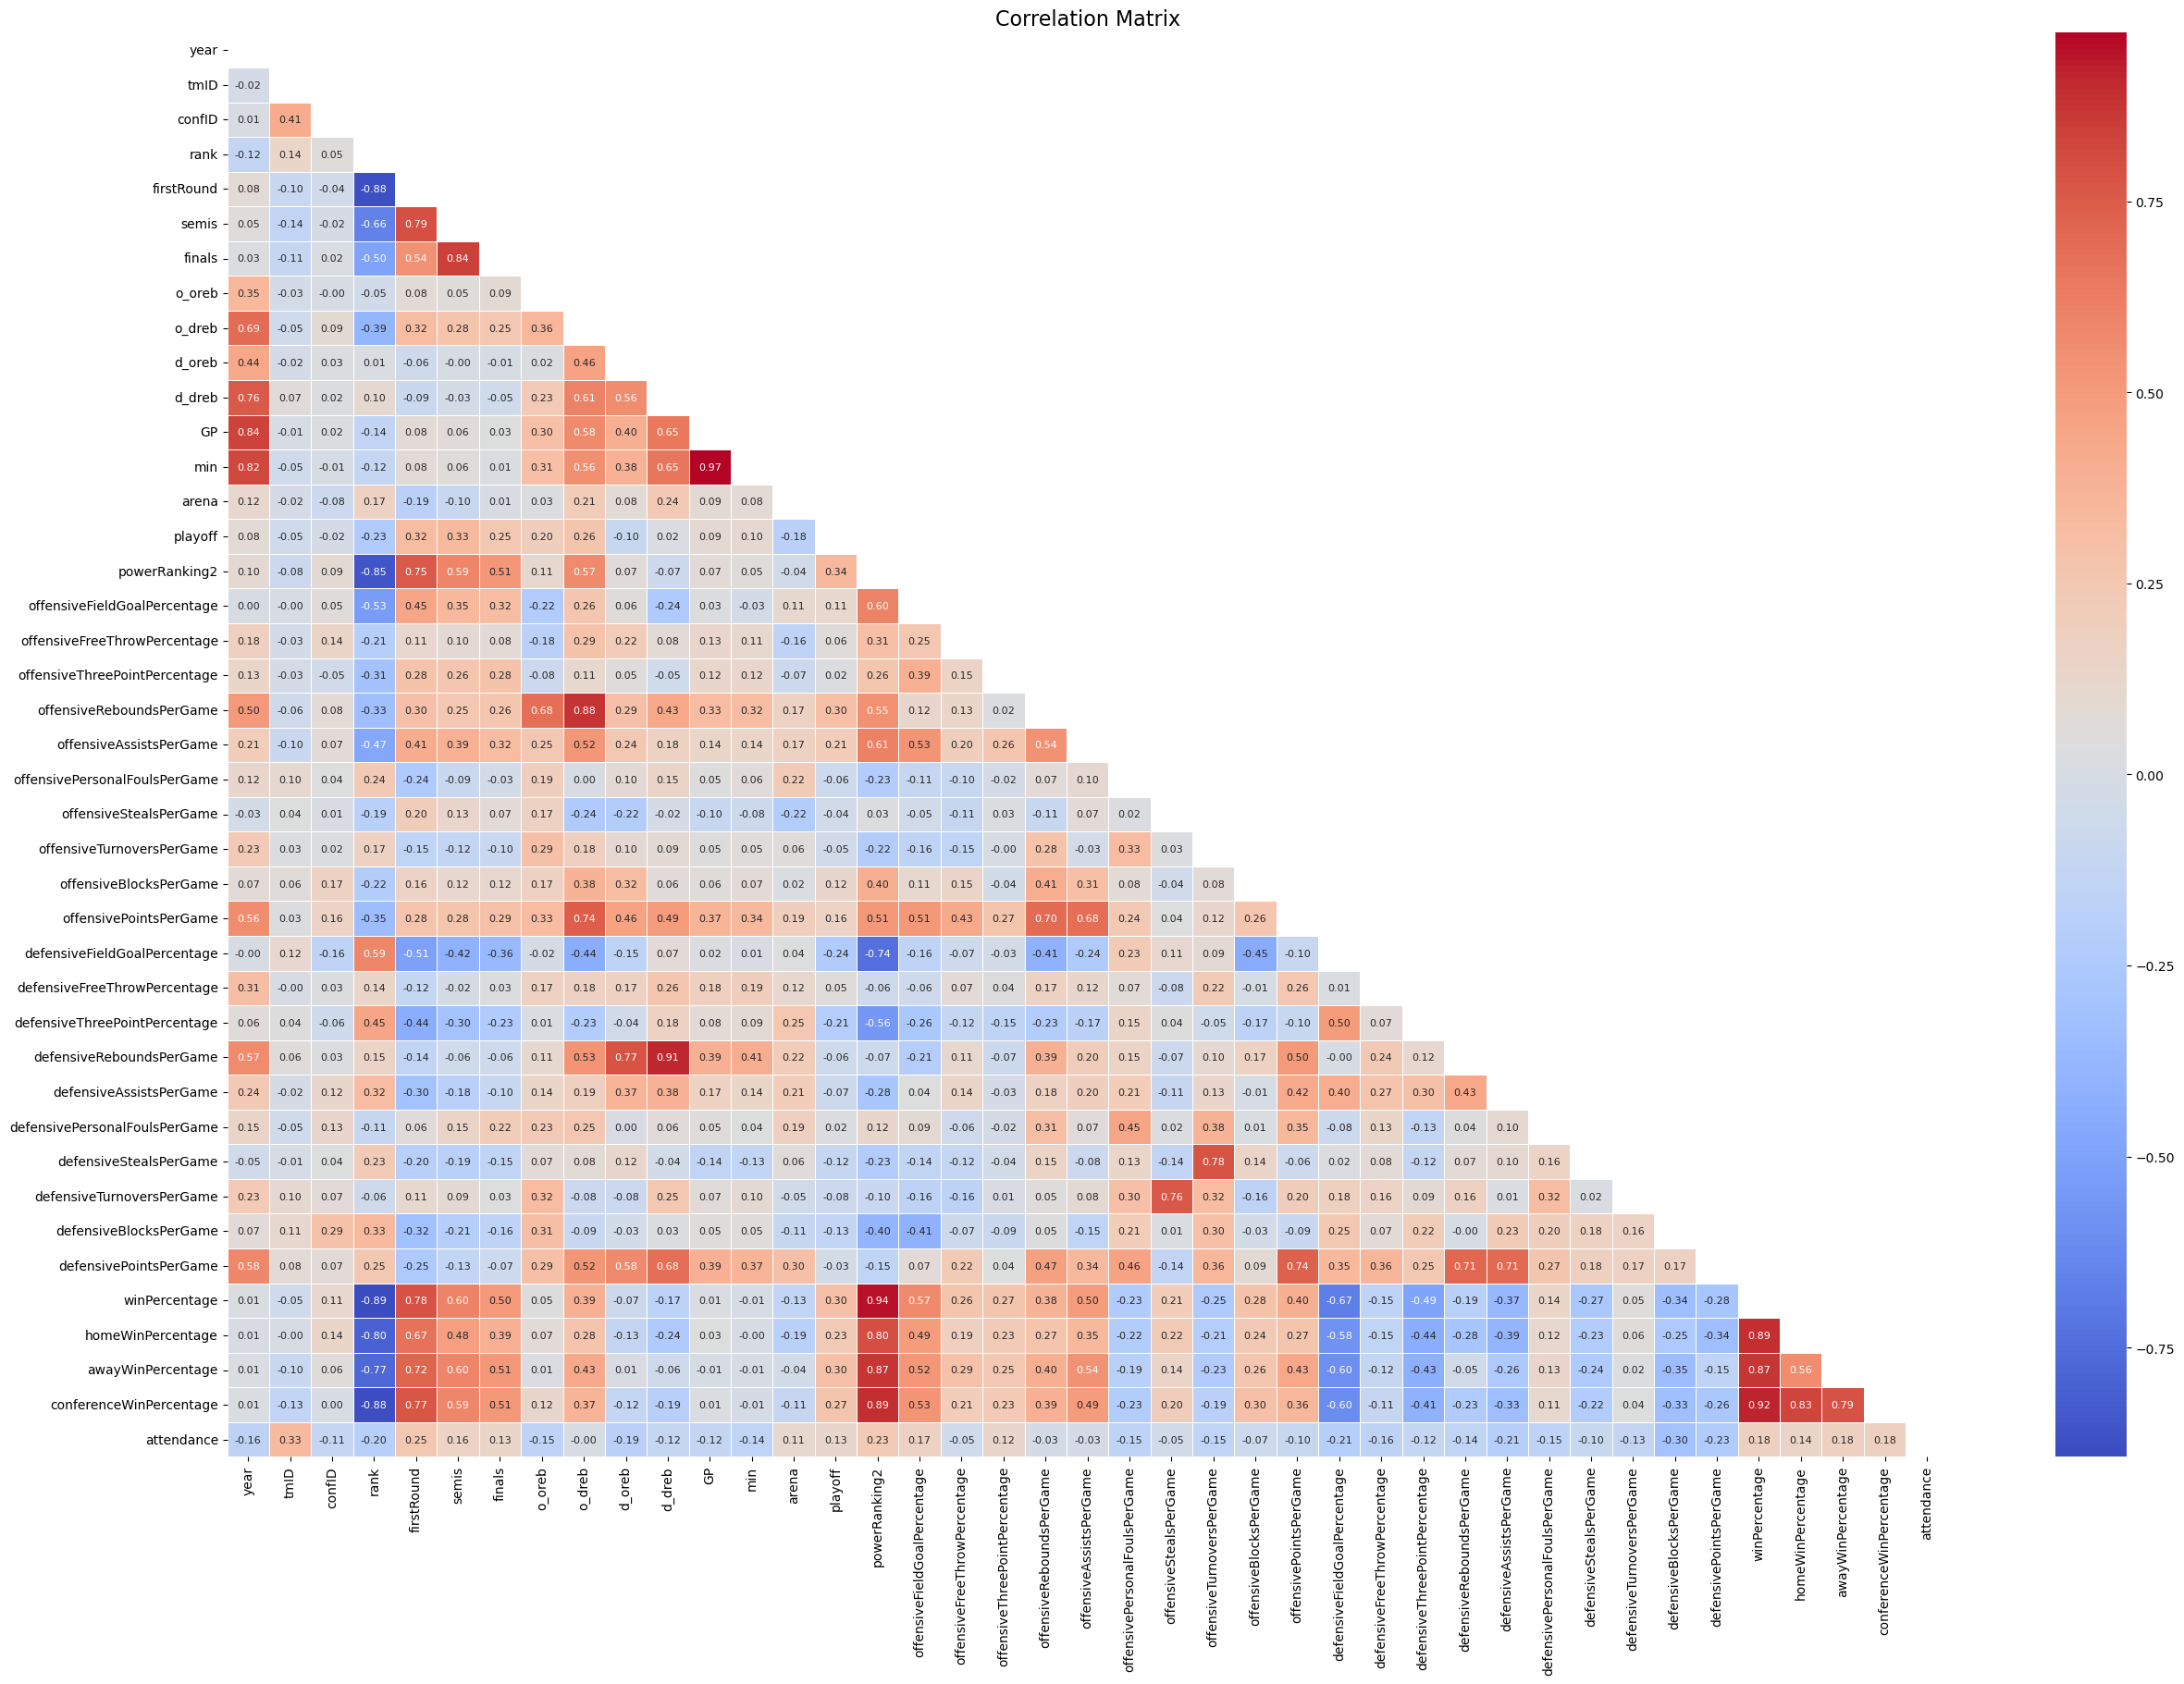

Correlation between target and year: 0.08230252844177124
Correlation between target and tmID: -0.05178357638364355
Correlation between target and confID: -0.022078749693891626
Correlation between target and rank: -0.23447156884008877
Correlation between target and firstRound: 0.31711626412189603
Correlation between target and semis: 0.3333984489762754
Correlation between target and finals: 0.2478110294883341
Correlation between target and o_oreb: 0.19723591348627054
Correlation between target and o_dreb: 0.2649630650233743
Correlation between target and d_oreb: -0.10232115132727775
Correlation between target and d_dreb: 0.01692793633446554
Correlation between target and GP: 0.09020678776091365
Correlation between target and min: 0.09959604664638144
Correlation between target and arena: -0.18191310143996453
Correlation between target and playoff: 1.0
Correlation between target and powerRanking2: 0.3444608063724295
Correlation between target and offensiveFieldGoalPercentage: 0.1147248400

In [409]:
team2 = teams.copy()

for index, team in team2.iterrows(): 
    powerRanking = team_power_ranking_2(team, features_weight)

    team2.at[index, 'powerRanking2'] = powerRanking['powerRanking2']
    team2.at[index, 'offensiveFieldGoalPercentage'] = powerRanking['offensiveFieldGoalPercentage']
    team2.at[index, 'offensiveFreeThrowPercentage'] = powerRanking['offensiveFreeThrowPercentage']
    team2.at[index, 'offensiveThreePointPercentage'] = powerRanking['offensiveThreePointPercentage']
    team2.at[index, 'offensiveReboundsPerGame'] = powerRanking['offensiveReboundsPerGame']
    team2.at[index, 'offensiveAssistsPerGame'] = powerRanking['offensiveAssistsPerGame']
    team2.at[index, 'offensivePersonalFoulsPerGame'] = powerRanking['offensivePersonalFoulsPerGame']
    team2.at[index, 'offensiveStealsPerGame'] = powerRanking['offensiveStealsPerGame']
    team2.at[index, 'offensiveTurnoversPerGame'] = powerRanking['offensiveTurnoversPerGame']
    team2.at[index, 'offensiveBlocksPerGame'] = powerRanking['offensiveBlocksPerGame']
    team2.at[index, 'offensivePointsPerGame'] = powerRanking['offensivePointsPerGame']
    team2.at[index, 'defensiveFieldGoalPercentage'] = powerRanking['defensiveFieldGoalPercentage']
    team2.at[index, 'defensiveFreeThrowPercentage'] = powerRanking['defensiveFreeThrowPercentage']
    team2.at[index, 'defensiveThreePointPercentage'] = powerRanking['defensiveThreePointPercentage']
    team2.at[index, 'defensiveReboundsPerGame'] = powerRanking['defensiveReboundsPerGame']
    team2.at[index, 'defensiveAssistsPerGame'] = powerRanking['defensiveAssistsPerGame']
    team2.at[index, 'defensivePersonalFoulsPerGame'] = powerRanking['defensivePersonalFoulsPerGame']
    team2.at[index, 'defensiveStealsPerGame'] = powerRanking['defensiveStealsPerGame']
    team2.at[index, 'defensiveTurnoversPerGame'] = powerRanking['defensiveTurnoversPerGame']
    team2.at[index, 'defensiveBlocksPerGame'] = powerRanking['defensiveBlocksPerGame']
    team2.at[index, 'defensivePointsPerGame'] = powerRanking['defensivePointsPerGame']
    team2.at[index, 'winPercentage'] = powerRanking['winPercentage']
    team2.at[index, 'homeWinPercentage'] = powerRanking['homeWinPercentage']
    team2.at[index, 'awayWinPercentage'] = powerRanking['awayWinPercentage']
    team2.at[index, 'conferenceWinPercentage'] = powerRanking['conferenceWinPercentage']
    team2.at[index, 'attendance'] = powerRanking['attendance']


team2 = team2.drop(columns=['o_fgm', 'o_fga', 'o_ftm', 'o_fta', 'o_3pm', 'o_3pa', 'o_reb', 'o_asts', 'o_pf', 'o_stl', 'o_to', 'o_blk', 'o_pts', 'd_fgm', 'd_fga', 'd_ftm', 'd_fta', 'd_3pm', 'd_3pa', 'd_reb', 'd_asts', 'd_pf', 'd_stl', 'd_to', 'd_blk', 'd_pts', 'won', 'lost', 'homeW', 'homeL', 'awayW', 'awayL', 'confW', 'confL', 'attend'])
team2 = team2.drop(columns=['lgID', 'divID', 'seeded', 'tmORB', 'tmDRB', 'tmTRB', 'opptmORB', 'opptmDRB', 'opptmTRB'])

features_weight = correlation_matrix(team2)

In [410]:
for index, team in teams_original.iterrows(): 
    powerRanking = team_power_ranking_2(team, features_weight)

    teams_original.at[index, 'powerRanking2'] = powerRanking['powerRanking2']
    teams_original.at[index, 'offensiveFieldGoalPercentage'] = powerRanking['offensiveFieldGoalPercentage']
    teams_original.at[index, 'offensiveFreeThrowPercentage'] = powerRanking['offensiveFreeThrowPercentage']
    teams_original.at[index, 'offensiveThreePointPercentage'] = powerRanking['offensiveThreePointPercentage']
    teams_original.at[index, 'offensiveReboundsPerGame'] = powerRanking['offensiveReboundsPerGame']
    teams_original.at[index, 'offensiveAssistsPerGame'] = powerRanking['offensiveAssistsPerGame']
    teams_original.at[index, 'offensivePersonalFoulsPerGame'] = powerRanking['offensivePersonalFoulsPerGame']
    teams_original.at[index, 'offensiveStealsPerGame'] = powerRanking['offensiveStealsPerGame']
    teams_original.at[index, 'offensiveTurnoversPerGame'] = powerRanking['offensiveTurnoversPerGame']
    teams_original.at[index, 'offensiveBlocksPerGame'] = powerRanking['offensiveBlocksPerGame']
    teams_original.at[index, 'offensivePointsPerGame'] = powerRanking['offensivePointsPerGame']
    teams_original.at[index, 'defensiveFieldGoalPercentage'] = powerRanking['defensiveFieldGoalPercentage']
    teams_original.at[index, 'defensiveFreeThrowPercentage'] = powerRanking['defensiveFreeThrowPercentage']
    teams_original.at[index, 'defensiveThreePointPercentage'] = powerRanking['defensiveThreePointPercentage']
    teams_original.at[index, 'defensiveReboundsPerGame'] = powerRanking['defensiveReboundsPerGame']
    teams_original.at[index, 'defensiveAssistsPerGame'] = powerRanking['defensiveAssistsPerGame']
    teams_original.at[index, 'defensivePersonalFoulsPerGame'] = powerRanking['defensivePersonalFoulsPerGame']
    teams_original.at[index, 'defensiveStealsPerGame'] = powerRanking['defensiveStealsPerGame']
    teams_original.at[index, 'defensiveTurnoversPerGame'] = powerRanking['defensiveTurnoversPerGame']
    teams_original.at[index, 'defensiveBlocksPerGame'] = powerRanking['defensiveBlocksPerGame']
    teams_original.at[index, 'defensivePointsPerGame'] = powerRanking['defensivePointsPerGame']
    teams_original.at[index, 'winPercentage'] = powerRanking['winPercentage']
    teams_original.at[index, 'homeWinPercentage'] = powerRanking['homeWinPercentage']
    teams_original.at[index, 'awayWinPercentage'] = powerRanking['awayWinPercentage']
    teams_original.at[index, 'conferenceWinPercentage'] = powerRanking['conferenceWinPercentage']
    teams_original.at[index, 'attendance'] = powerRanking['attendance']


teams_original = teams_original.drop(columns=['o_fgm', 'o_fga', 'o_ftm', 'o_fta', 'o_3pm', 'o_3pa', 'o_reb', 'o_asts', 'o_pf', 'o_stl', 'o_to', 'o_blk', 'o_pts', 'd_fgm', 'd_fga', 'd_ftm', 'd_fta', 'd_3pm', 'd_3pa', 'd_reb', 'd_asts', 'd_pf', 'd_stl', 'd_to', 'd_blk', 'd_pts', 'won', 'lost', 'homeW', 'homeL', 'awayW', 'awayL', 'confW', 'confL', 'attend'])
teams_original = teams_original.drop(columns=['lgID', 'divID', 'seeded', 'tmORB', 'tmDRB', 'tmTRB', 'opptmORB', 'opptmDRB', 'opptmTRB'])

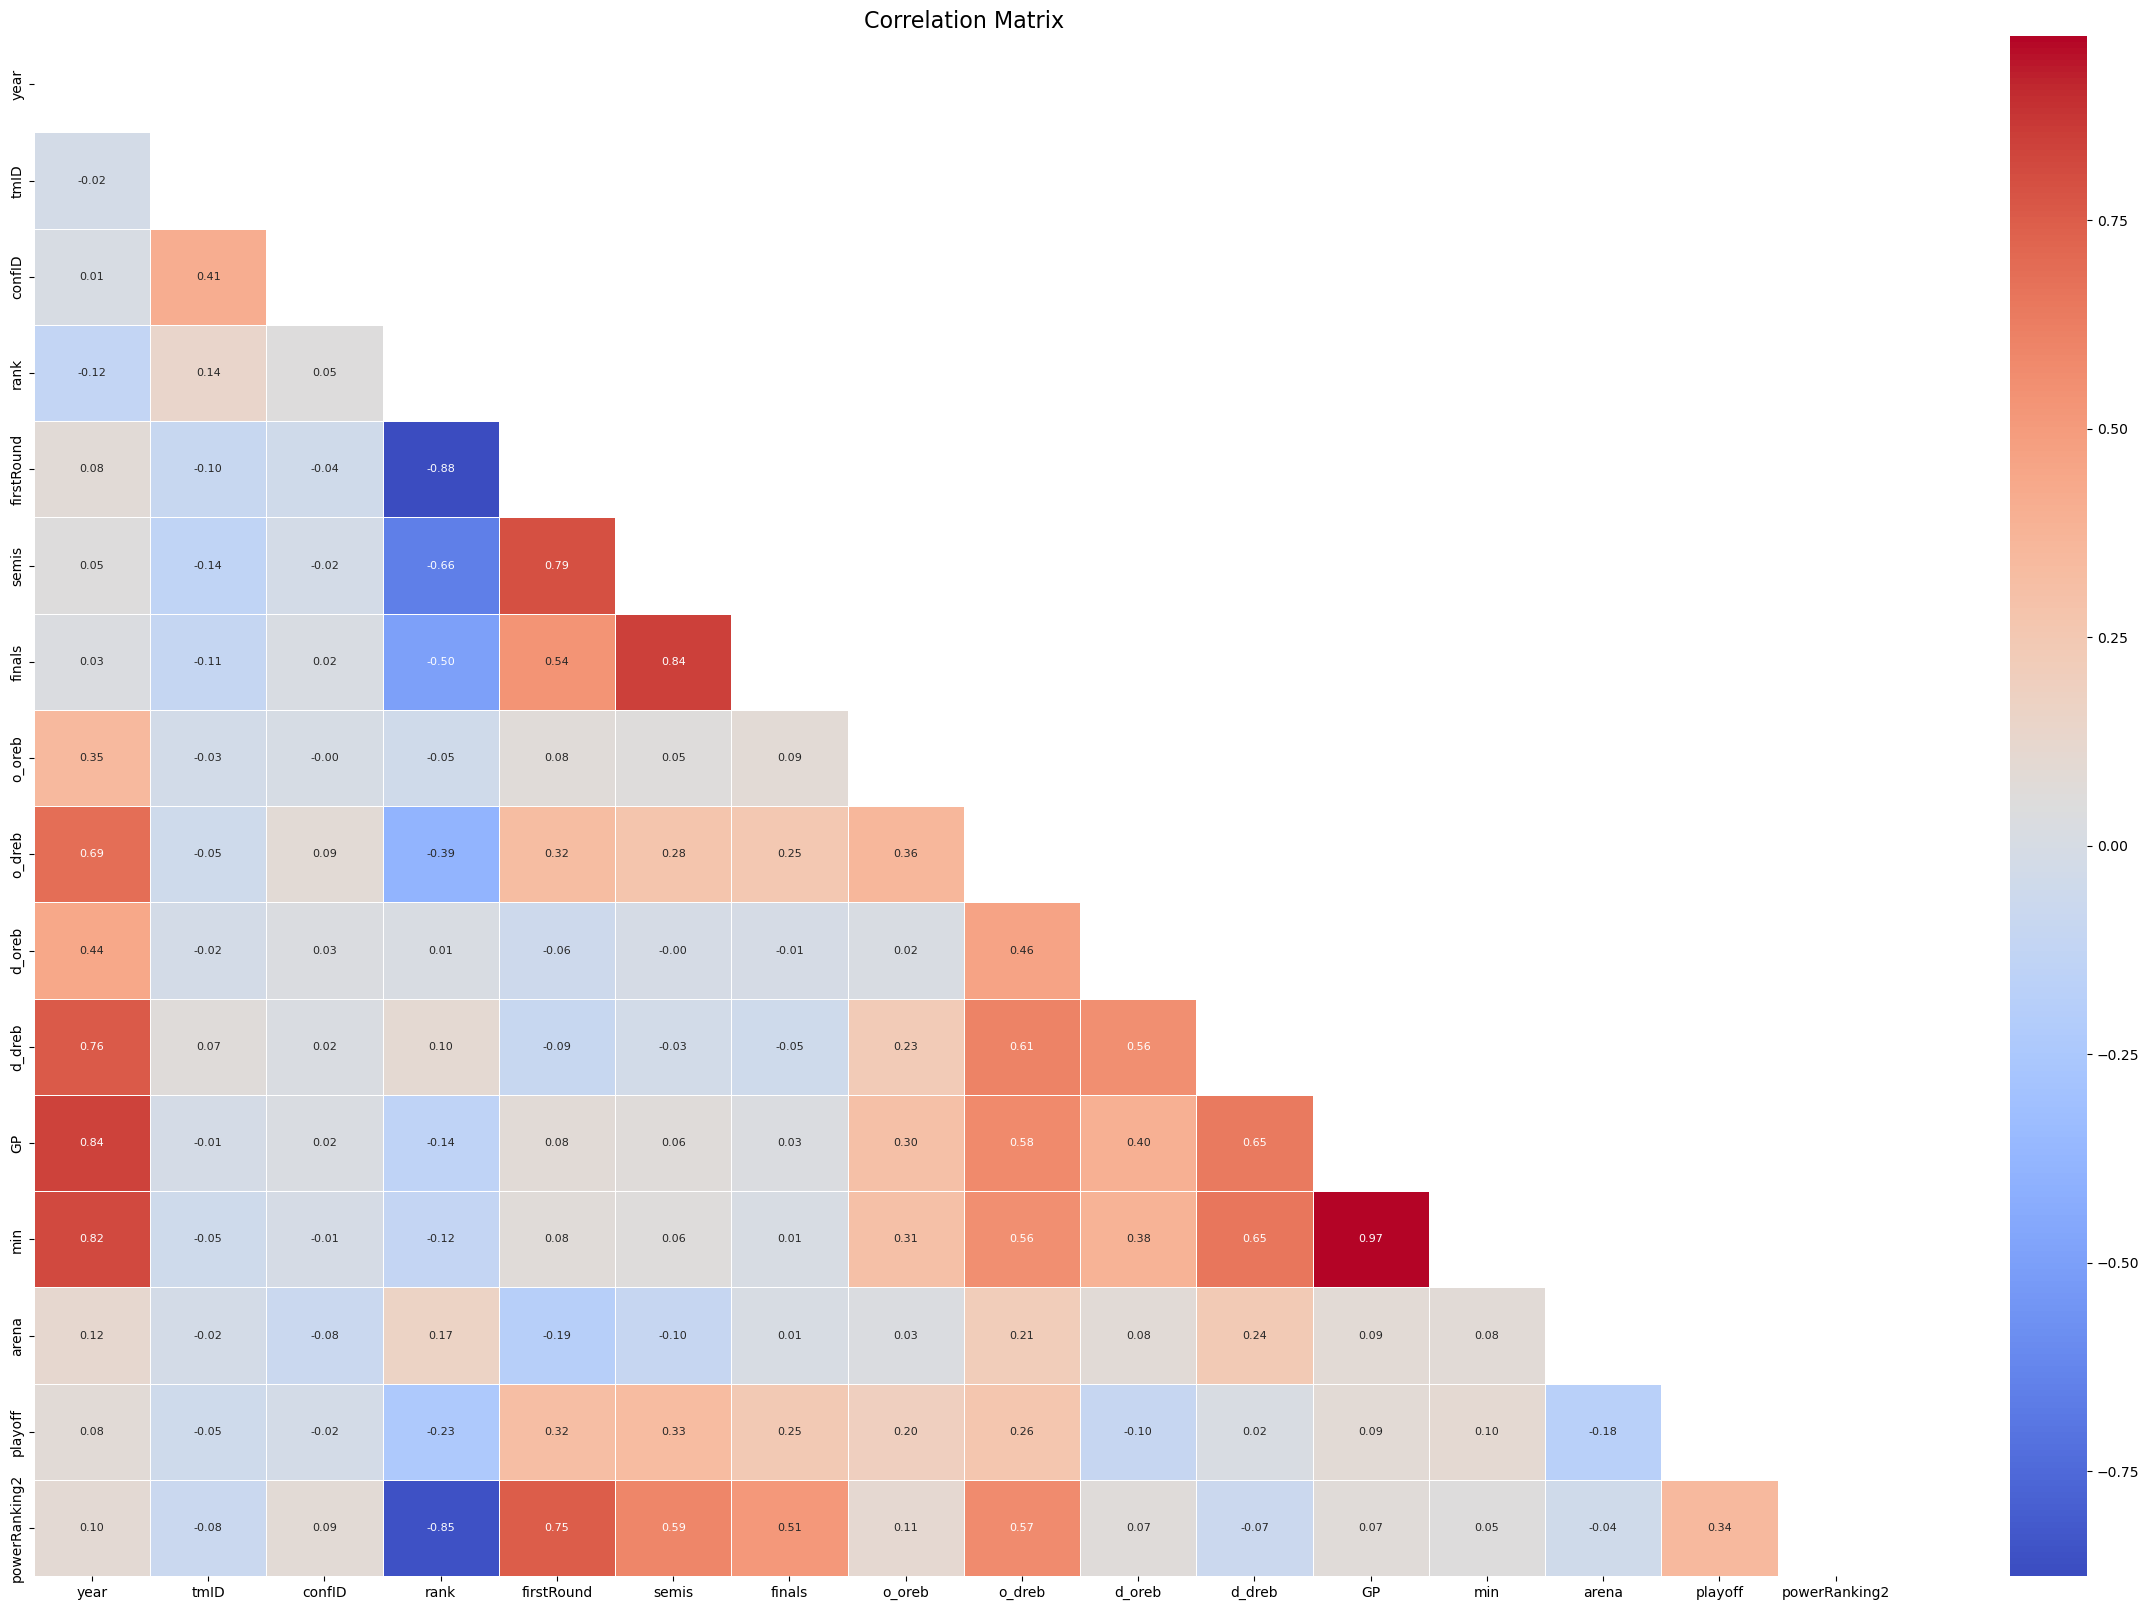

Correlation between target and year: 0.08230252844177124
Correlation between target and tmID: -0.05178357638364355
Correlation between target and confID: -0.022078749693891626
Correlation between target and rank: -0.23447156884008877
Correlation between target and firstRound: 0.31711626412189603
Correlation between target and semis: 0.3333984489762754
Correlation between target and finals: 0.2478110294883341
Correlation between target and o_oreb: 0.19723591348627054
Correlation between target and o_dreb: 0.2649630650233743
Correlation between target and d_oreb: -0.10232115132727775
Correlation between target and d_dreb: 0.01692793633446554
Correlation between target and GP: 0.09020678776091365
Correlation between target and min: 0.09959604664638144
Correlation between target and arena: -0.18191310143996453
Correlation between target and playoff: 1.0
Correlation between target and powerRanking2: 0.3444608063724295


{'year': 0.08230252844177124,
 'tmID': -0.05178357638364355,
 'confID': -0.022078749693891626,
 'rank': -0.23447156884008877,
 'firstRound': 0.31711626412189603,
 'semis': 0.3333984489762754,
 'finals': 0.2478110294883341,
 'o_oreb': 0.19723591348627054,
 'o_dreb': 0.2649630650233743,
 'd_oreb': -0.10232115132727775,
 'd_dreb': 0.01692793633446554,
 'GP': 0.09020678776091365,
 'min': 0.09959604664638144,
 'arena': -0.18191310143996453,
 'playoff': 1.0,
 'powerRanking2': 0.3444608063724295}

In [411]:
relevantFeatures = [ 'offensiveFieldGoalPercentage', 'offensiveFreeThrowPercentage', 'offensiveThreePointPercentage', 'offensiveReboundsPerGame', 'offensiveAssistsPerGame', 
                        'offensivePersonalFoulsPerGame', 'offensiveStealsPerGame', 'offensiveTurnoversPerGame', 'offensiveBlocksPerGame', 'offensivePointsPerGame', 
                        'defensiveFieldGoalPercentage', 'defensiveFreeThrowPercentage', 'defensiveThreePointPercentage', 'defensiveReboundsPerGame', 'defensiveAssistsPerGame', 
                        'defensivePersonalFoulsPerGame', 'defensiveStealsPerGame', 'defensiveTurnoversPerGame', 'defensiveBlocksPerGame', 'defensivePointsPerGame', 'winPercentage', 
                        'homeWinPercentage', 'awayWinPercentage', 'conferenceWinPercentage', 'attendance' ]

for feature in relevantFeatures:
    team2 = team2.drop(feature, axis=1)
    teams_original = teams_original.drop(feature, axis=1)

correlation_matrix(team2)

Now we have a much shorter dataframe, but as we can see the relation between minutes and games played is really big, so we can delete games played. 

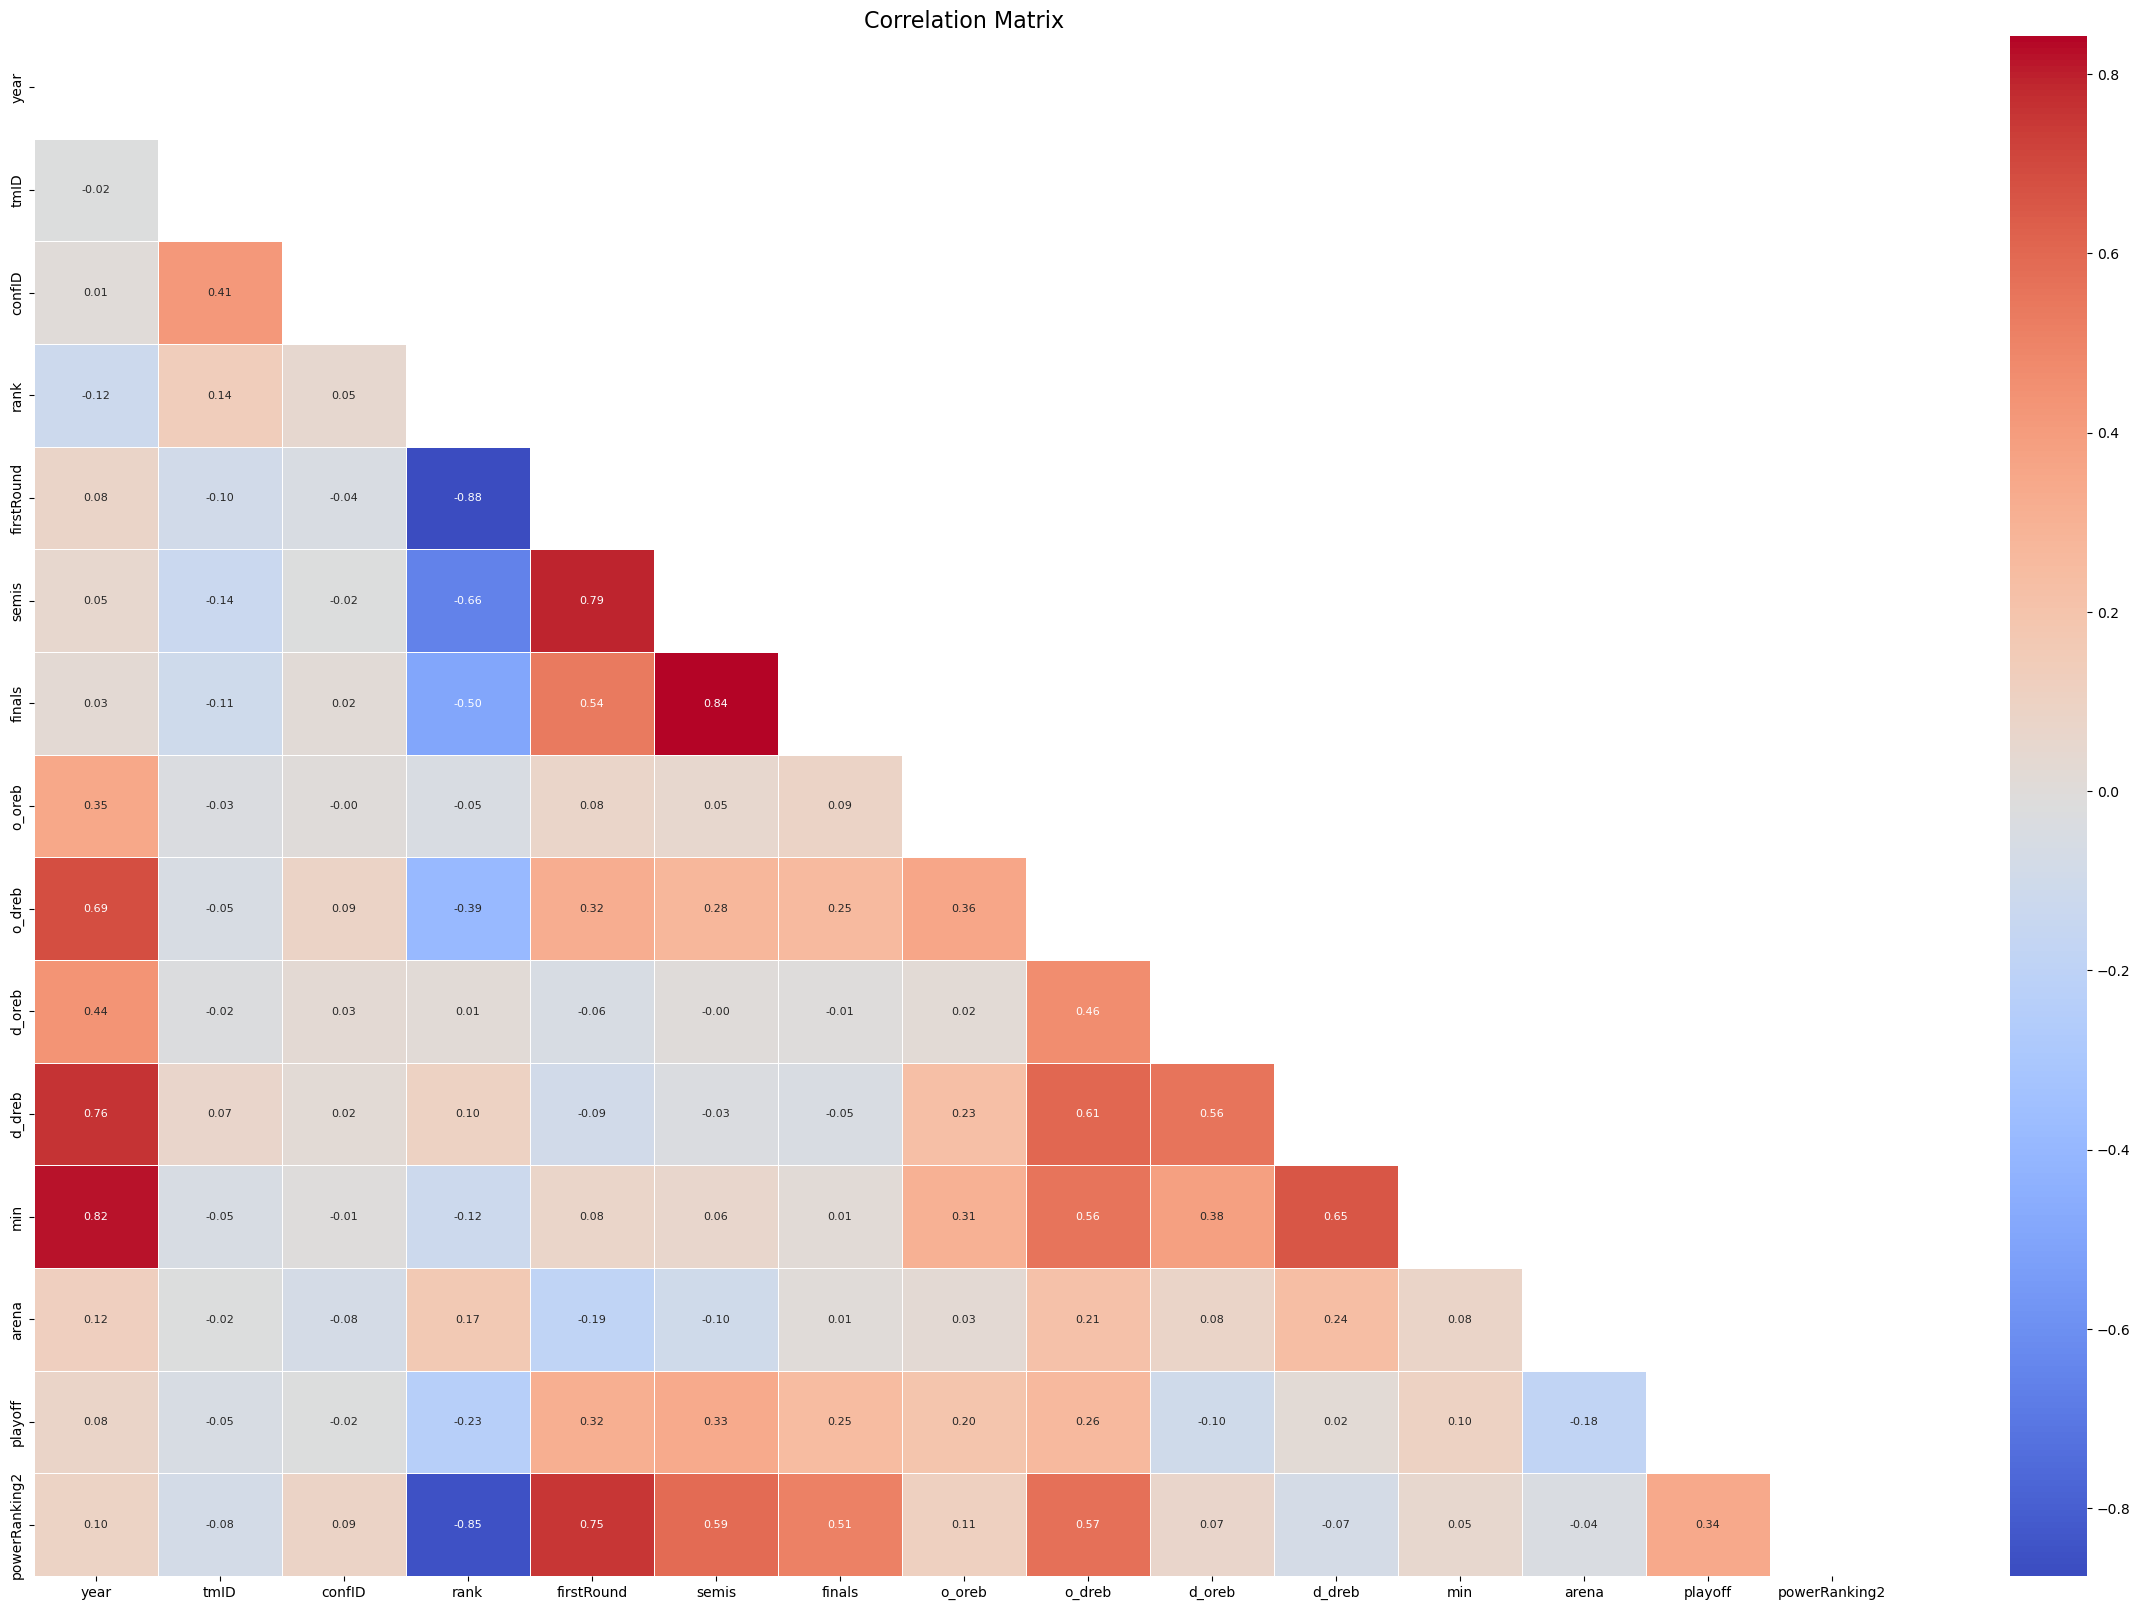

Correlation between target and year: 0.08230252844177124
Correlation between target and tmID: -0.05178357638364355
Correlation between target and confID: -0.022078749693891626
Correlation between target and rank: -0.23447156884008877
Correlation between target and firstRound: 0.31711626412189603
Correlation between target and semis: 0.3333984489762754
Correlation between target and finals: 0.2478110294883341
Correlation between target and o_oreb: 0.19723591348627054
Correlation between target and o_dreb: 0.2649630650233743
Correlation between target and d_oreb: -0.10232115132727775
Correlation between target and d_dreb: 0.01692793633446554
Correlation between target and min: 0.09959604664638144
Correlation between target and arena: -0.18191310143996453
Correlation between target and playoff: 1.0
Correlation between target and powerRanking2: 0.3444608063724295


In [412]:
team2 = team2.drop('GP', axis=1)
teams_original = teams_original.drop('GP', axis=1)
#team2.to_csv('filtered/team2.csv', index=False)
correlation_matrix(team2)

teams_original.to_csv('filtered/team2.csv', index=False)